# HubMap- Hacking the Kidney
#### Goal - Mapping the human body at function tissue unit level - detect glomeruli FTUs in kidney

#### Implementation of Notebook using TFRecords to train a UNet

Link - https://www.kaggle.com/marcosnovaes/hubmap-3-unet-models-with-keras-cpu-gpu

###### Step 1 - Import useful libraries

In [1]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from keras.layers.core import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from keras.engine.topology import Layer
from tensorflow.keras.optimizers import Adam
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
import glob

###### Step 2 - Read TF records (masks and images)

In [2]:
# Create a dictionary describing the features.
image_feature_description = {
    'img_index': tf.io.FixedLenFeature([], tf.int64),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'num_channels': tf.io.FixedLenFeature([], tf.int64),
    'img_bytes': tf.io.FixedLenFeature([], tf.string),
    'mask': tf.io.FixedLenFeature([], tf.string),
    'tile_id': tf.io.FixedLenFeature([], tf.int64),
    'tile_col_pos': tf.io.FixedLenFeature([], tf.int64),
    'tile_row_pos': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_and_masks_function(example_proto):
    single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    img_height = single_example['height']
    img_width = single_example['width']
    num_channels = single_example['num_channels']
    
    img_bytes =  tf.io.decode_raw(single_example['img_bytes'],out_type='uint8')
    img_array = tf.reshape( img_bytes, (1,512, 512, 3))
    
    mask_bytes =  tf.io.decode_raw(single_example['mask'],out_type='bool')    
    mask = tf.reshape(mask_bytes, (1,512,512))
    
    #cast to float 32
    img_array = tf.cast(img_array, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32)
    return img_array, mask

def _parse_mask_function(example_proto):
    single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    img_height = single_example['height']
    img_width = single_example['width']
    num_channels = single_example['num_channels']   
    mask_bytes =  tf.io.decode_raw(single_example['mask'],out_type='bool') 
    mask = tf.reshape(mask_bytes, (img_height,img_width))
    return mask

def read_tf_dataset(storage_file_path):
    encoded_image_dataset = tf.data.TFRecordDataset(storage_file_path, compression_type="GZIP")
    parsed_image_dataset = encoded_image_dataset.map(_parse_image_data_function)
    return parsed_image_dataset

def read_images_and_masks(storage_file_path):
    encoded_image_dataset = tf.data.TFRecordDataset(storage_file_path, compression_type="GZIP")
    parsed_image_dataset = encoded_image_dataset.map(_parse_image_and_masks_function)
    return parsed_image_dataset

def read_masks(storage_file_path):
    encoded_image_dataset = tf.data.TFRecordDataset(storage_file_path, compression_type="GZIP")
    parsed_image_dataset = encoded_image_dataset.map(_parse_mask_function)
    return parsed_image_dataset


In [8]:
basepath = r'C:/Users/soodn/Downloads/Naveksha/Kaggle HuBMAP/Scripts/0. Pipeline/Output/'

train_all = basepath+'output_train_all_tiles.csv'
test_all = basepath+'output_test_all_tiles.csv'

train_all_df = pd.read_csv(train_all)
test_all_df = pd.read_csv(test_all)

file_list = glob.glob(basepath+'output_train/*.csv')
file_list

['C:/Users/soodn/Downloads/Naveksha/Kaggle HuBMAP/Scripts/0. Pipeline/Output/output_train\\0486052bb_tiles.csv',
 'C:/Users/soodn/Downloads/Naveksha/Kaggle HuBMAP/Scripts/0. Pipeline/Output/output_train\\095bf7a1f_tiles.csv',
 'C:/Users/soodn/Downloads/Naveksha/Kaggle HuBMAP/Scripts/0. Pipeline/Output/output_train\\1e2425f28_tiles.csv',
 'C:/Users/soodn/Downloads/Naveksha/Kaggle HuBMAP/Scripts/0. Pipeline/Output/output_train\\26dc41664_tiles.csv',
 'C:/Users/soodn/Downloads/Naveksha/Kaggle HuBMAP/Scripts/0. Pipeline/Output/output_train\\2f6ecfcdf_tiles.csv',
 'C:/Users/soodn/Downloads/Naveksha/Kaggle HuBMAP/Scripts/0. Pipeline/Output/output_train\\4ef6695ce_tiles.csv',
 'C:/Users/soodn/Downloads/Naveksha/Kaggle HuBMAP/Scripts/0. Pipeline/Output/output_train\\54f2eec69_tiles.csv',
 'C:/Users/soodn/Downloads/Naveksha/Kaggle HuBMAP/Scripts/0. Pipeline/Output/output_train\\8242609fa_tiles.csv',
 'C:/Users/soodn/Downloads/Naveksha/Kaggle HuBMAP/Scripts/0. Pipeline/Output/output_train\\aaa6a

In [9]:
train_all_df

Unnamed: 0     img_id  tile_id  tile_row_index  tile_col_index  \
0               0  0486052bb        0               0               0   
1               1  0486052bb        1               0               1   
2               2  0486052bb        2               0               2   
3               3  0486052bb        3               0               3   
4               4  0486052bb        4               0               4   
...           ...        ...      ...             ...             ...   
63373       63373  e79de561c     1607              30              47   
63374       63374  e79de561c     1608              30              48   
63375       63375  e79de561c     1609              30              49   
63376       63376  e79de561c     1610              30              50   
63377       63377  e79de561c     1611              30              51   

       lowband_density  mask_density  \
0                    0             0   
1                    0             0   
2                    0             0   
3                    0             0   
4                    0             0   
...                ...           ...   
63373              618             0   
63374               62             0   
63375              123             0   
63376               76             0   
63377              542             0   

                                              local_path  
0      Output/output_train/0486052bb/col0/col0_row0.t...  
1      Output/output_train/0486052bb/col0/col0_row1.t...  
2      Output/output_train/0486052bb/col0/col0_row2.t...  
3      Output/output_train/0486052bb/col0/col0_row3.t...  
4      Output/output_train/0486052bb/col0/col0_row4.t...  
...                                                  ...  
63373  Output/output_train/e79de561c/col30/col30_row4...  
63374  Output/output_train/e79de561c/col30/col30_row4...  
63375  Output/output_train/e79de561c/col30/col30_row4...  
63376  Output/output_train/e79de561c/col30/col30_row5...  
63377  Output/output_train/e79de561c/col30/col30_row5...  

[63378 rows x 8 columns]

In [10]:
gloms_df = train_all_df.loc[train_all_df["mask_density"]  > 0]

balance = train_all_df[0:12000]
rest = train_all_df[12000:].loc[train_all_df["mask_density"]  > 0]
balance_df = pd.concat([balance, rest])

len(gloms_df), len(balance)

(7921, 12000)

###### Step 3 - Low band intensity filter; build unet model.

In [11]:
cropped_df = train_all_df.loc[train_all_df["lowband_density"]  > 1000]
cropped_df

Unnamed: 0     img_id  tile_id  tile_row_index  tile_col_index  \
5               5  0486052bb        5               0               5   
6               6  0486052bb        6               0               6   
7               7  0486052bb        7               0               7   
8               8  0486052bb        8               0               8   
9               9  0486052bb        9               0               9   
...           ...        ...      ...             ...             ...   
63336       63336  e79de561c     1570              30              10   
63354       63354  e79de561c     1588              30              28   
63358       63358  e79de561c     1592              30              32   
63363       63363  e79de561c     1597              30              37   
63364       63364  e79de561c     1598              30              38   

       lowband_density  mask_density  \
5               430752             0   
6                49152             0   
7                49152             0   
8                50592             0   
9                50688             0   
...                ...           ...   
63336            19743             0   
63354             1932             0   
63358             5968             0   
63363            35134             0   
63364            48250             0   

                                              local_path  
5      Output/output_train/0486052bb/col0/col0_row5.t...  
6      Output/output_train/0486052bb/col0/col0_row6.t...  
7      Output/output_train/0486052bb/col0/col0_row7.t...  
8      Output/output_train/0486052bb/col0/col0_row8.t...  
9      Output/output_train/0486052bb/col0/col0_row9.t...  
...                                                  ...  
63336  Output/output_train/e79de561c/col30/col30_row1...  
63354  Output/output_train/e79de561c/col30/col30_row2...  
63358  Output/output_train/e79de561c/col30/col30_row3...  
63363  Output/output_train/e79de561c/col30/col30_row3...  
63364  Output/output_train/e79de561c/col30/col30_row3...  

[42672 rows x 8 columns]

In [12]:
def dice_coeff(y_true, y_pred):
    # add epsilon to avoid a divide by 0 error in case a slice has no pixels set
    # we only care about relative value, not absolute so this alteration doesn't matter
    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)
    return dice_scores

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
  
get_custom_objects().update({"dice": dice_loss})

class LayerNormalization (Layer) :
    
    def call(self, x, mask=None, training=None) :
        axis = list (range (1, len (x.shape)))
        x /= K.std (x, axis = axis, keepdims = True) + K.epsilon()
        x -= K.mean (x, axis = axis, keepdims = True)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape
    
class LayerNormalization2 (Layer) :
    
    def call(self, x, mask=None, training=None) :
        axis = list (range (1, len (x.shape)))
        _epsilon = 10 ** -7
        x /= tf.math.reduce_std (x, axis = axis, keepdims = True) + _epsilon
        x -= tf.math.reduce_mean (x, axis = axis, keepdims = True)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape

In [13]:
def build_unet3(act_fn = 'relu', init_fn = 'he_normal', width=512, height = 512, channels = 3): 
    inputs = Input((512,512,3))
    act_fn = 'relu'
    init_fn = 'he_normal'

    # note we use linear function before layer normalization
    conv1 = Conv2D(8, 5, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(inputs)
    conv1 = LayerNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(pool2)
    conv3 = LayerNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(72, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool4)

    up6 = Conv2D(64, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv5))
    up6 = LayerNormalization()(up6)
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge6)

    up7 = Conv2D(32, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge7)

    up8 = Conv2D(16, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv7))
    up8 = LayerNormalization()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge8)

    up9 = Conv2D(8, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)

    return model


In [14]:
unet_model = build_unet3(512,512,3)

unet_model.compile(optimizer = Adam(lr = 1e-4), loss = 'dice', metrics=[dice_coeff])
unet_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 8)  608         input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 512, 512, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 8)  0           layer_normalization[0][0]        
_______________________________________________________________________________________

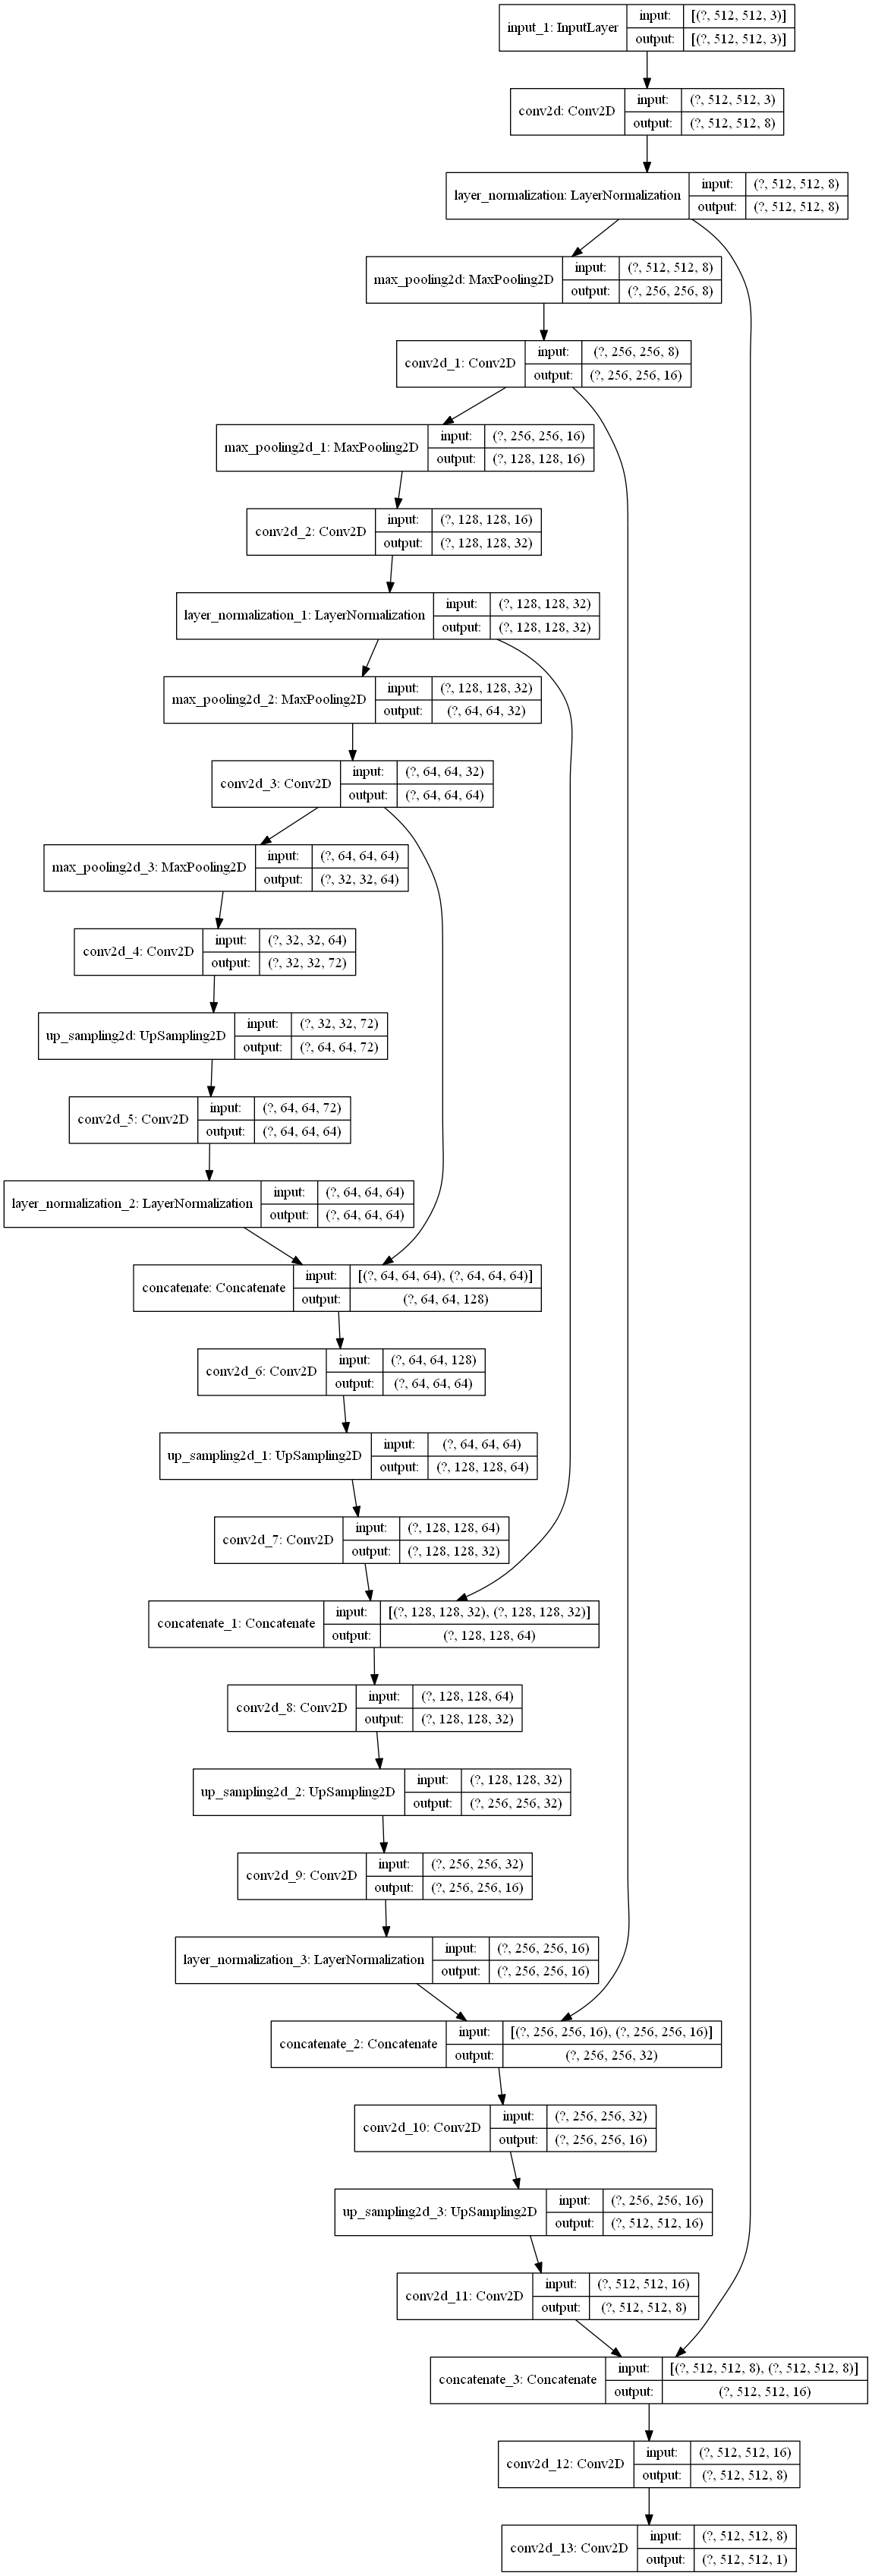

In [15]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

###### Step 4 - Train Test Split

In [16]:
train = gloms_df['local_path']
train_balance = balance_df['local_path']
train_dataset = read_images_and_masks(train)
train_balance_dataset =  read_images_and_masks(train_balance)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(<MapDataset shapes: ((1, 512, 512, 3), (1, 512, 512)), types: (tf.float32, tf.float32)>,
 <MapDataset shapes: ((1, 512, 512, 3), (1, 512, 512)), types: (tf.float32, tf.float32)>)

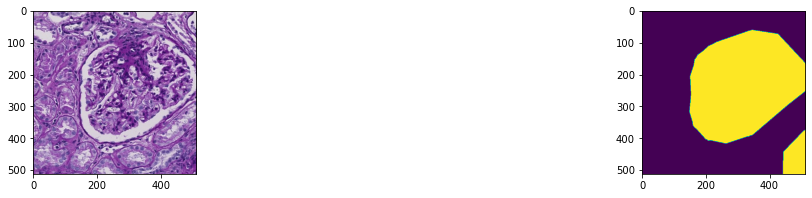

In [17]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image, mask

fig, ax = plt.subplots(1,2,figsize=(20,3))
ax[0].imshow(sample_image[0,:,:,:])
ax[1].imshow(sample_mask[0,:,:])

###### Step 5 - Model Training

In [18]:
# decide number of epochs
n_epochs = 1

In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint("Models/model-hubmap-"+str(n_epochs)+".h5", verbose=1)
# run 1 epoch
results = unet_model.fit(train_dataset, batch_size=4, epochs=n_epochs, callbacks=[checkpointer])

    550/Unknown - 297s 539ms/step - loss: 0.5863 - dice_coeff: 0.4137

In [229]:
unet_model.load_weights("Models/model-hubmap-"+str(n_epochs)+".h5")

In [230]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(basepath+"Models/model-balance-hubmap-"+str(n_epochs)+".h5", verbose=1)
# run 1 epoch
results = unet_model.fit(train_balance_dataset, batch_size=4, epochs=1, callbacks=[checkpointer])

  18361/Unknown - 13750s 749ms/step - loss: 0.7111 - dice_coeff: 0.2889
Epoch 00001: saving model to C:/Users/soodn/Downloads/Naveksha/hubmap-kidney-segmentation/models\model-balance-hubmap1.h5
18361/18361 [==============================] - 13750s 749ms/step - loss: 0.7111 - dice_coeff: 0.2889


In [231]:
unet_model.load_weights(basepath+"Models/model-balance-hubmap-"+str(n_epochs)+".h5")

###### Step 6 - Model Validation

In [236]:
def pixel_accuracy(groundtruth_list, predicted_list):
    n = 0
    d = 0
    for i, j in zip (groundtruth_list, predicted_list):
        if (i==j):
            n = n+1
        d = d+1
    
    return n/d

1/1 [==============================] - 0s 2ms/step
Dice Coefficient -  tf.Tensor(7.45075e-16, shape=(), dtype=float32)
Dice Loss -  tf.Tensor(1.0, shape=(), dtype=float32)
Pixel Accuracy -  0.0
Jaccard Index -  0.0
Hausdorff Distance -  (22.371058756484928, 172, 0)
1/1 [==============================] - 0s 998us/step
Dice Coefficient -  tf.Tensor(7.45075e-16, shape=(), dtype=float32)
Dice Loss -  tf.Tensor(1.0, shape=(), dtype=float32)
Pixel Accuracy -  0.0
Jaccard Index -  0.0
Hausdorff Distance -  (22.371058756484928, 172, 0)
1/1 [==============================] - 0s 2ms/step
Dice Coefficient -  tf.Tensor(7.45075e-16, shape=(), dtype=float32)
Dice Loss -  tf.Tensor(1.0, shape=(), dtype=float32)
Pixel Accuracy -  0.0
Jaccard Index -  0.0
Hausdorff Distance -  (22.371058756484928, 172, 0)
1/1 [==============================] - 0s 2ms/step
Dice Coefficient -  tf.Tensor(7.45075e-16, shape=(), dtype=float32)
Dice Loss -  tf.Tensor(1.0, shape=(), dtype=float32)
Pixel Accuracy -  0.0
Jaccar

<ipython-input-237-add743257a17>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,4,figsize=(20,3))


Dice Coefficient -  tf.Tensor(7.123596e-15, shape=(), dtype=float32)
Dice Loss -  tf.Tensor(1.0, shape=(), dtype=float32)
Pixel Accuracy -  0.8951187133789062
Jaccard Index -  0.0
Hausdorff Distance -  (0.00023012669382460163, 172, 146)
1/1 [==============================] - 0s 2ms/step
Dice Coefficient -  tf.Tensor(7.1486125e-15, shape=(), dtype=float32)
Dice Loss -  tf.Tensor(1.0, shape=(), dtype=float32)
Pixel Accuracy -  0.8957481384277344
Jaccard Index -  0.0
Hausdorff Distance -  (6.688209079319763e-05, 172, 92)
1/1 [==============================] - 0s 998us/step
Dice Coefficient -  tf.Tensor(7.109287e-15, shape=(), dtype=float32)
Dice Loss -  tf.Tensor(1.0, shape=(), dtype=float32)
Pixel Accuracy -  0.8951301574707031
Jaccard Index -  0.0
Hausdorff Distance -  (0.00022804900802896998, 172, 122)
1/1 [==============================] - 0s 997us/step
Dice Coefficient -  tf.Tensor(7.115743e-15, shape=(), dtype=float32)
Dice Loss -  tf.Tensor(1.0, shape=(), dtype=float32)
Pixel Accur

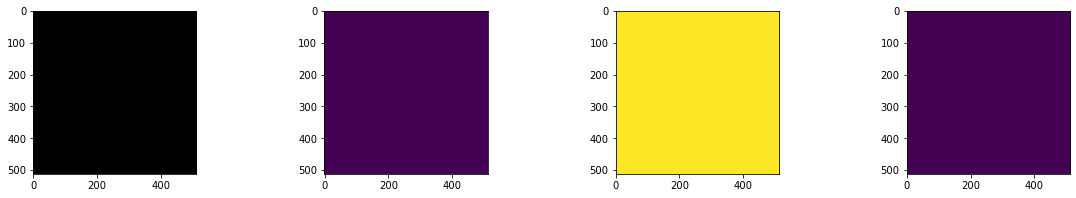

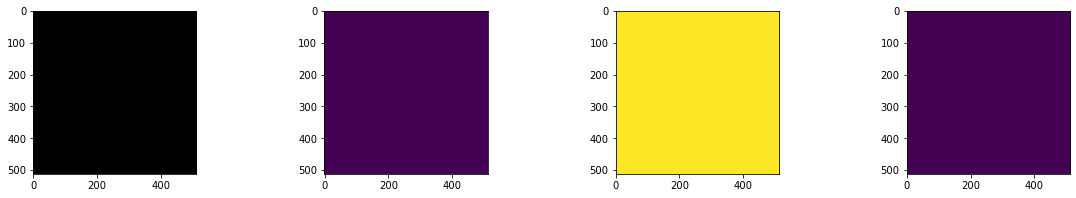

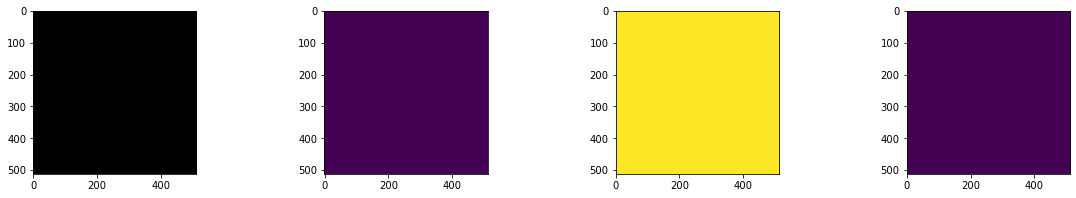

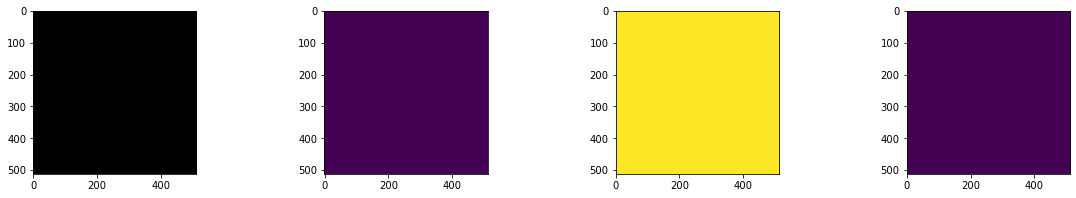

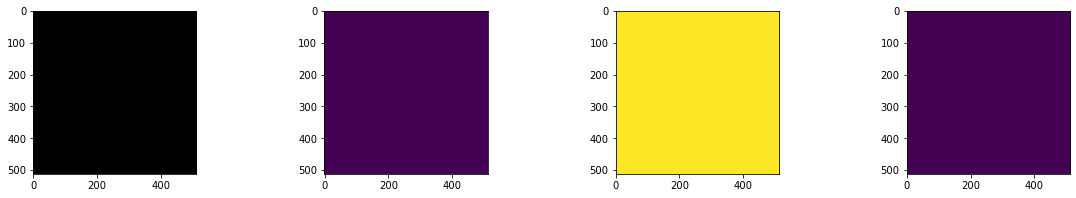

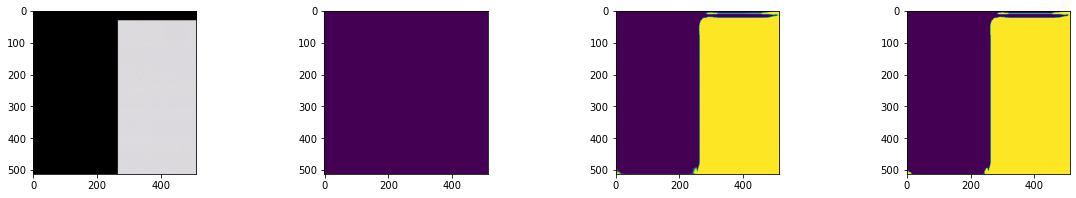

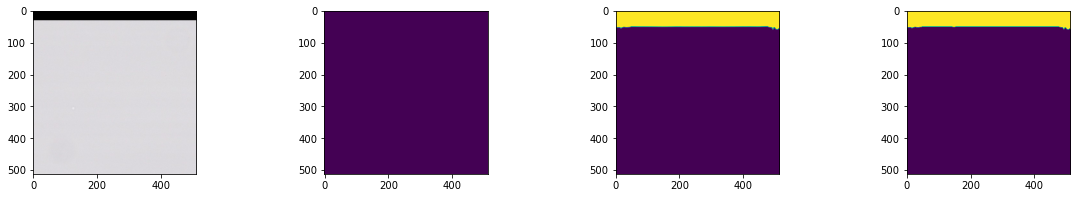

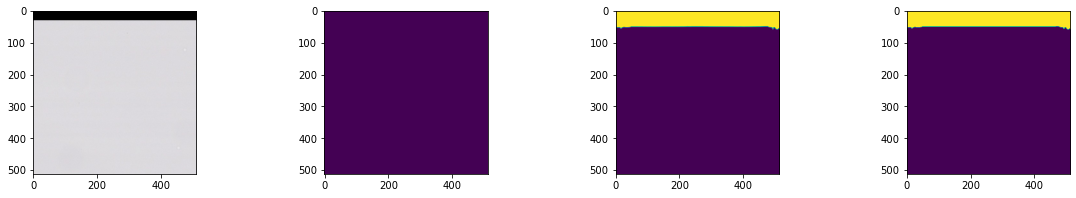

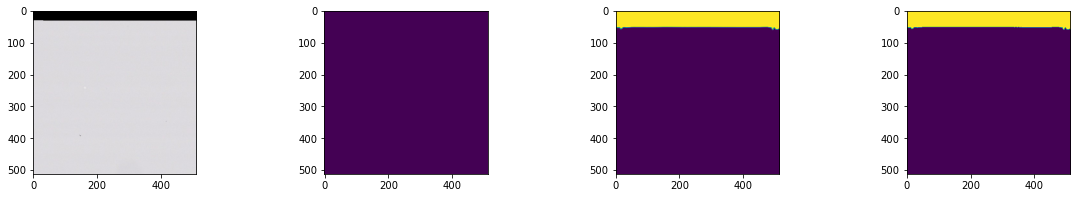

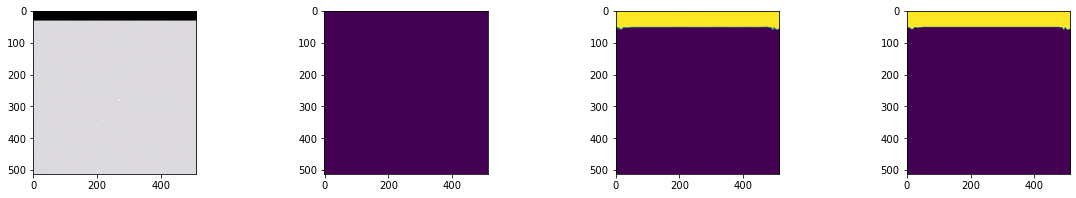

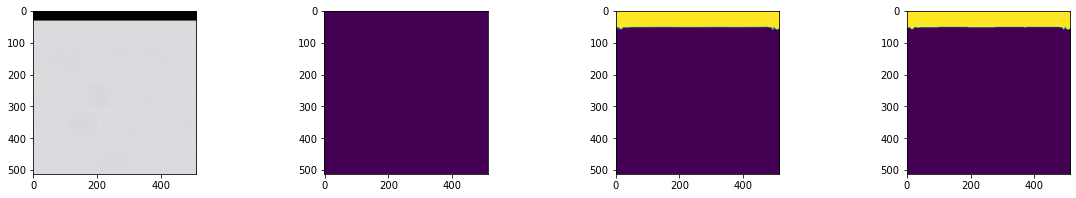

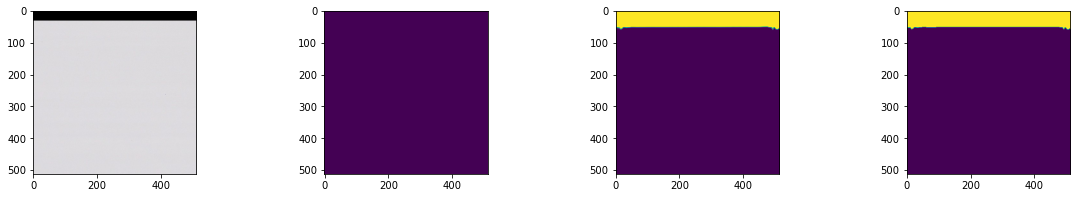

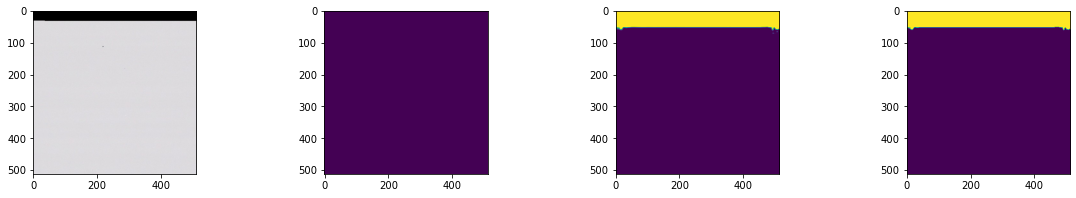

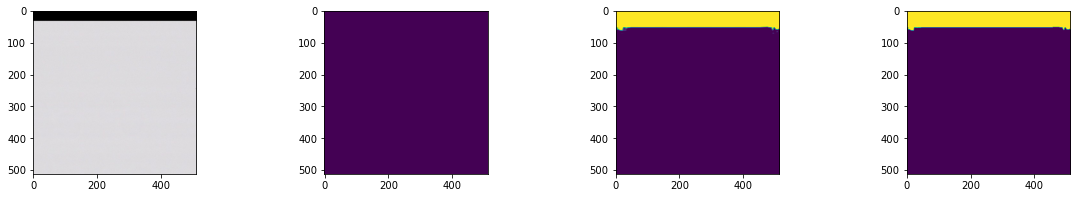

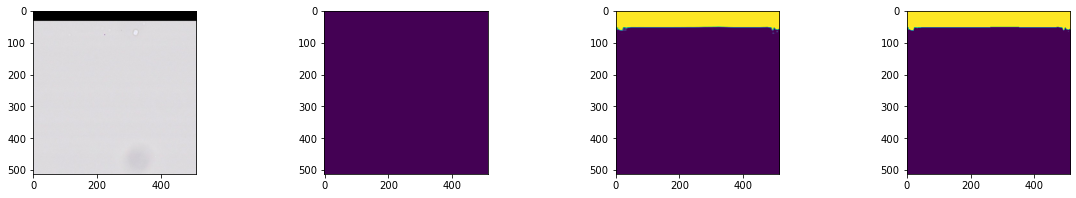

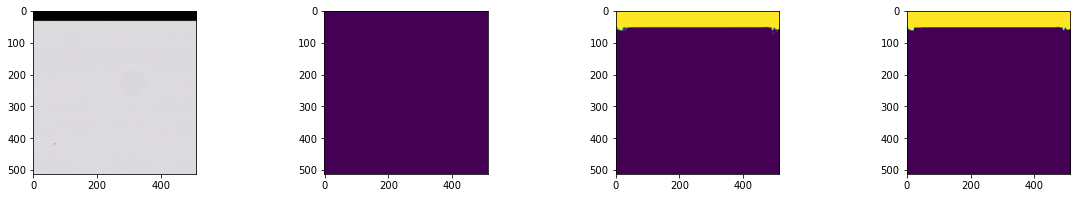

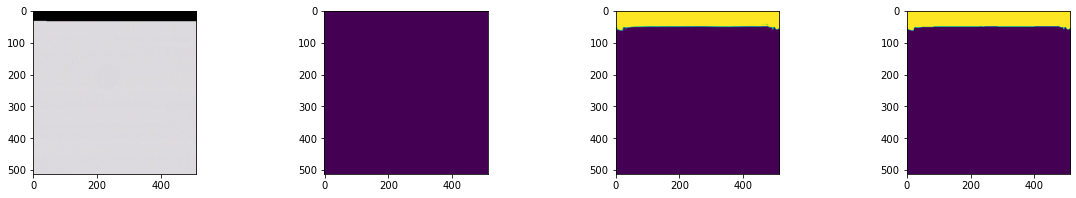

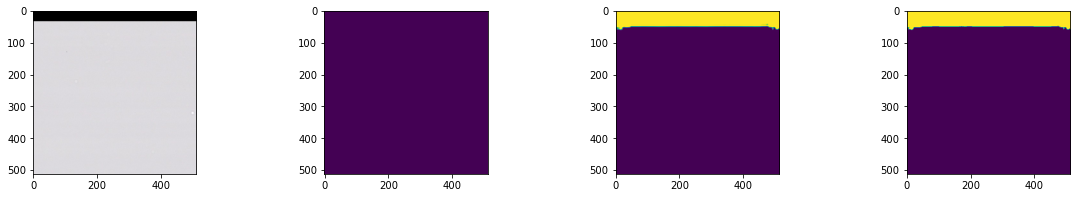

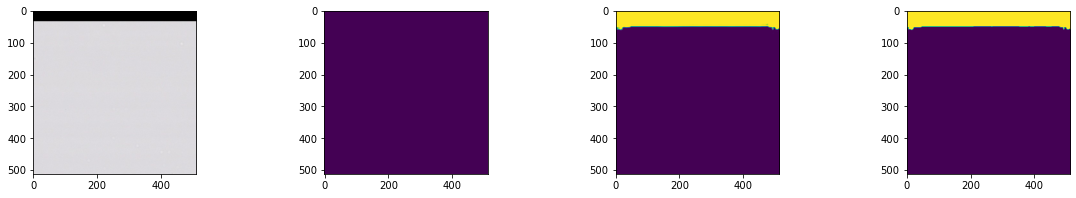

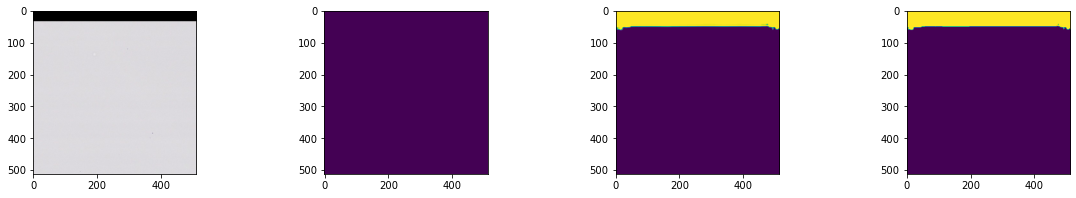

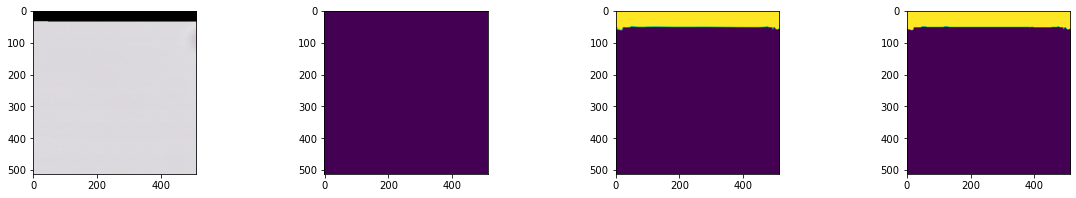

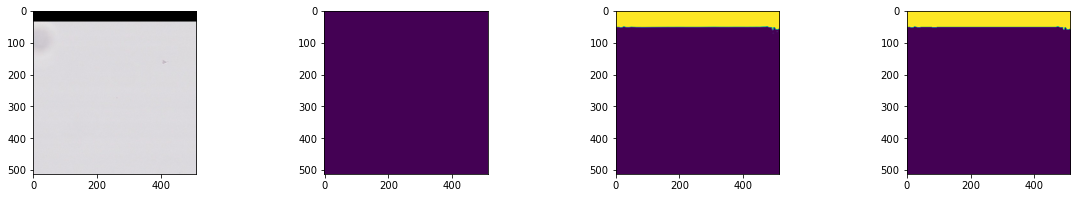

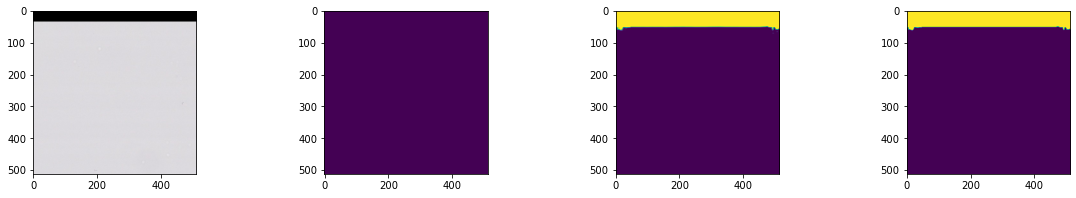

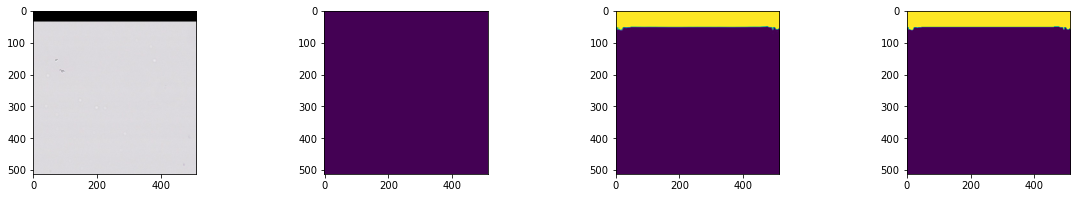

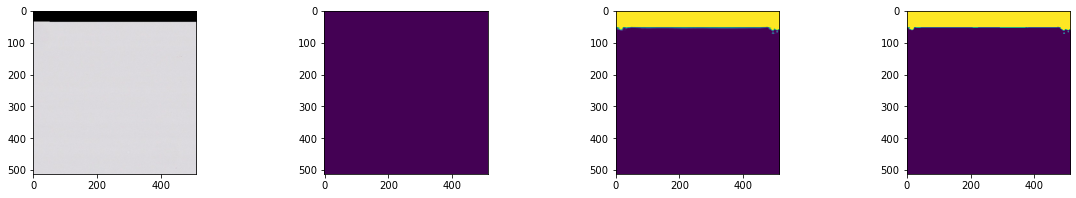

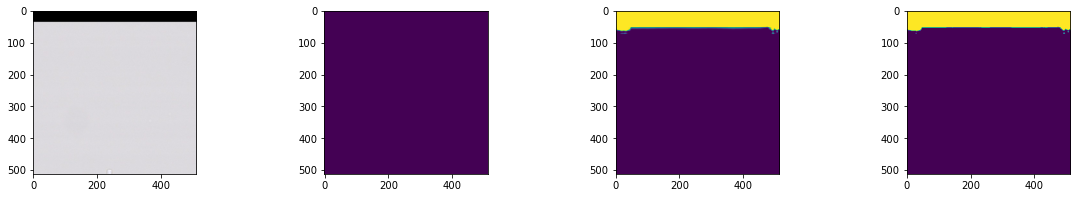

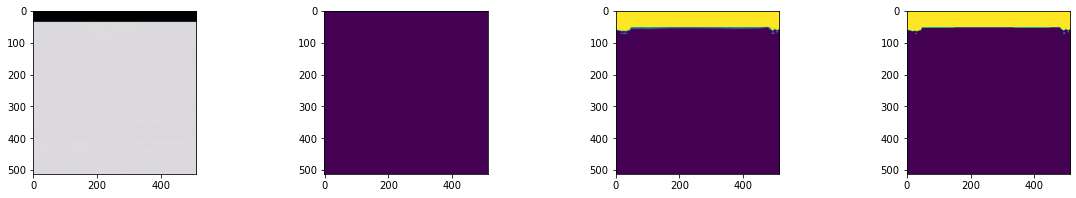

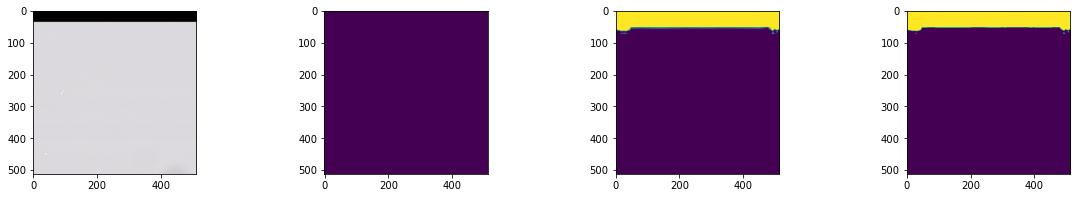

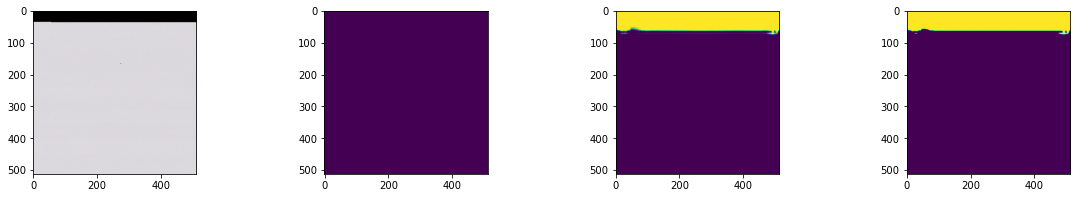

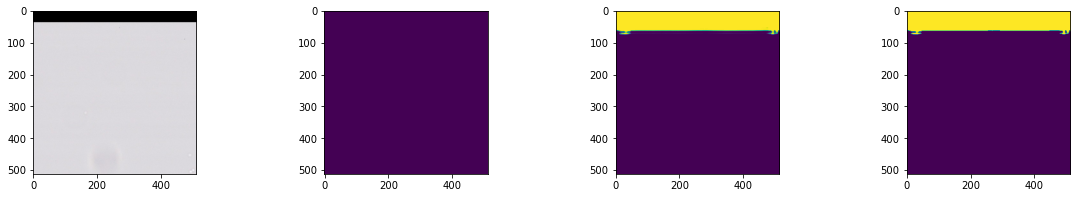

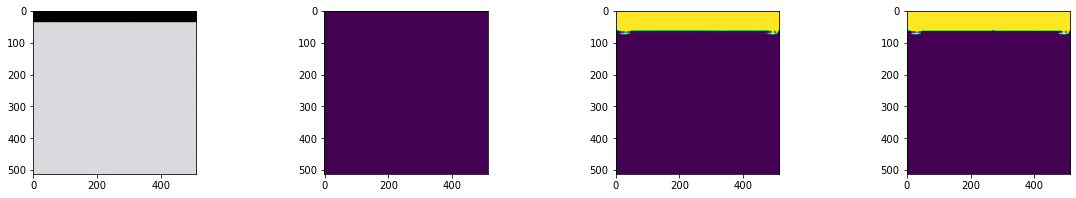

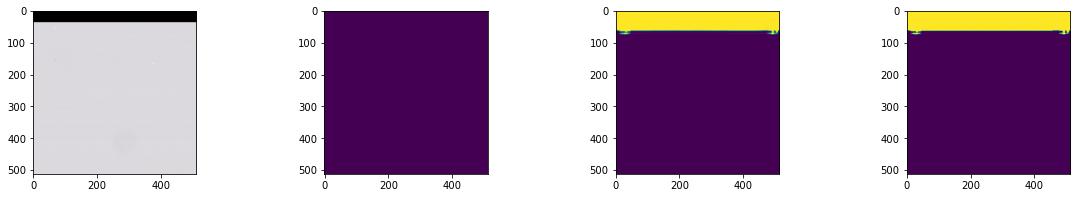

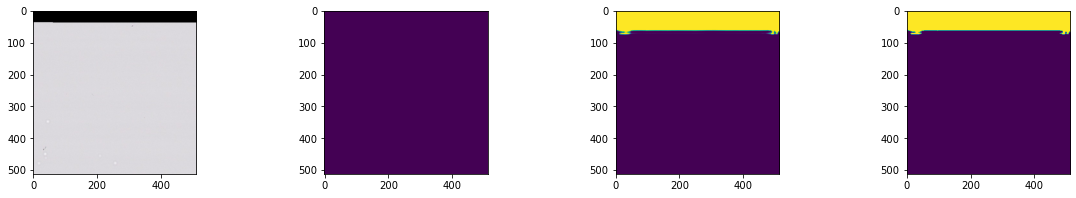

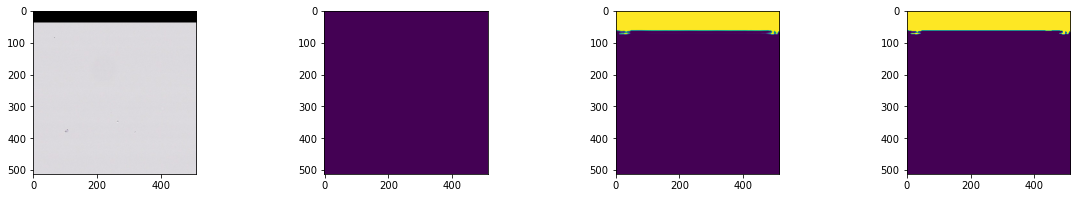

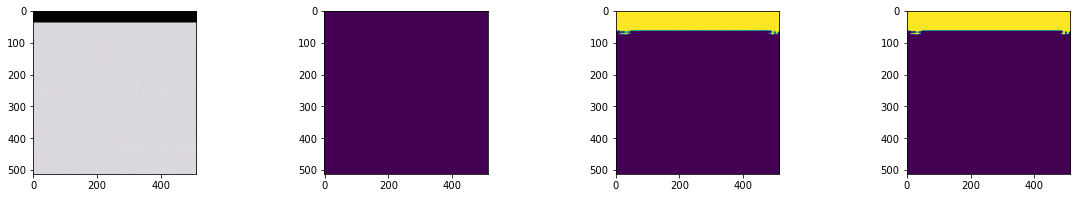

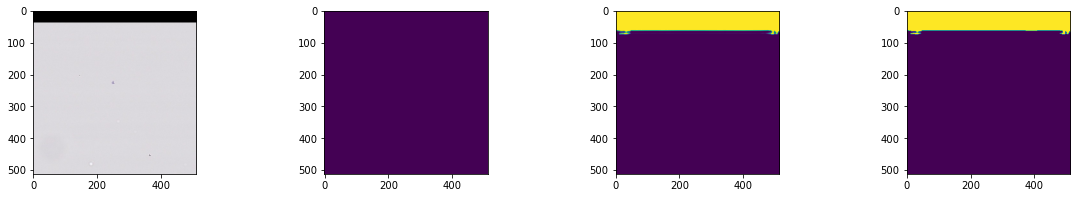

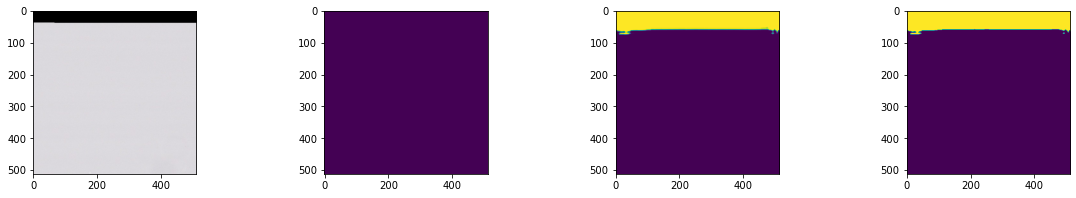

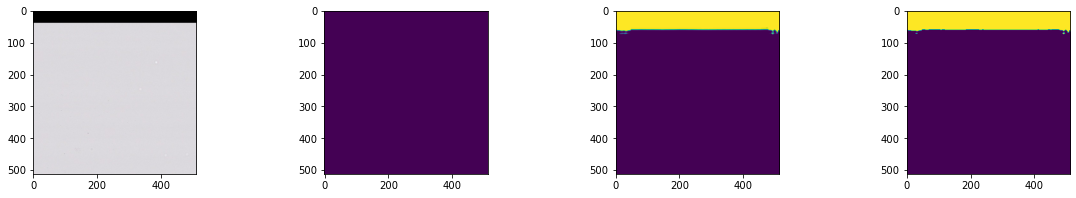

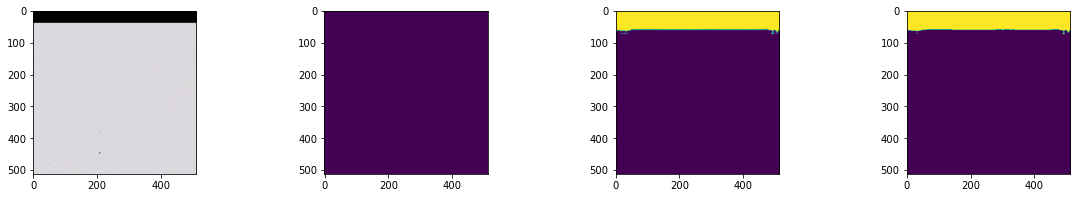

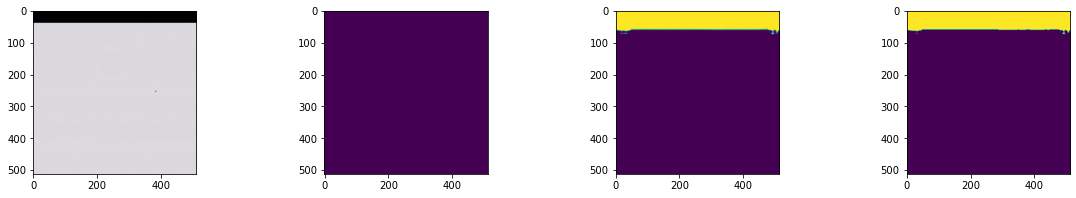

In [237]:
# For each test tile individually
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import directed_hausdorff

for image, mask in test_dataset.take(40):
    test_image, test_mask = image, mask
    pred_mask = unet_model.predict(test_image, verbose=1)
    bool_mask = pred_mask[:,:] > 0.5
    
    
    fig, ax = plt.subplots(1,4,figsize=(20,3))
    ax[0].imshow(test_image[0,:,:,:])
    ax[1].imshow(test_mask[0,:,:])
    ax[2].imshow(pred_mask[0,:,:])
    ax[3].imshow(bool_mask[0,:,:,0])

    print ("Dice Coefficient - " , dice_coeff(test_mask[0,:,:], pred_mask[0,:,:]))
    print ("Dice Loss - ", dice_loss(test_mask[0,:,:], pred_mask[0,:,:]))
    print ("Pixel Accuracy - " , pixel_accuracy(test_mask[0,:,:].numpy().flatten(order='C'), 1*bool_mask[0,:,:,0].flatten(order='C')))
    print ("Jaccard Index - ", jaccard_score(test_mask[0,:,:].numpy().flatten(order='C'), 1*bool_mask[0,:,:,0].flatten(order='C')))
    print ("Hausdorff Distance - ", directed_hausdorff(test_mask[0,:,:], pred_mask[0,:,:,0]))

1/1 [==============================] - 0s 997us/step


1/1 [==============================] - 0s 3ms/step


<ipython-input-234-1d7bba90657f>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2,figsize=(20,3))


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 998us/step


1/1 [==============================] - 0s 999us/step


1/1 [==============================] - 0s 2ms/step


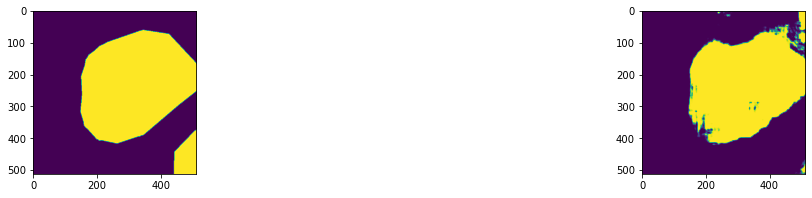

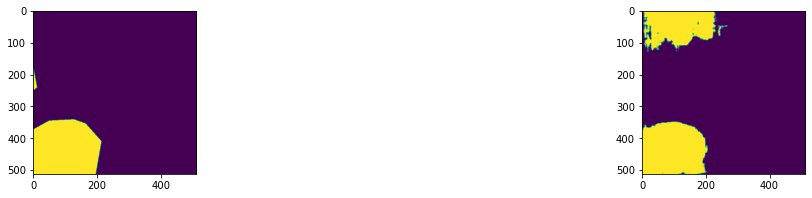

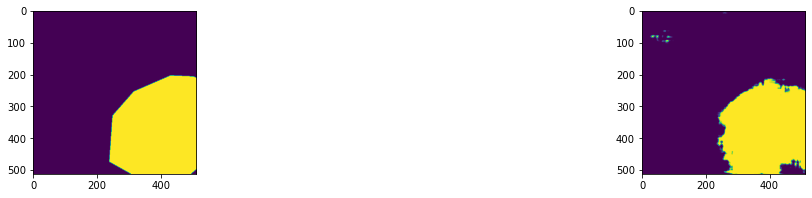

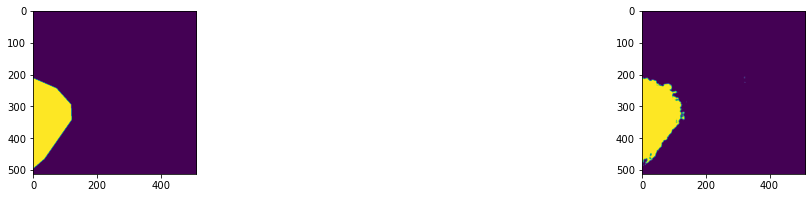

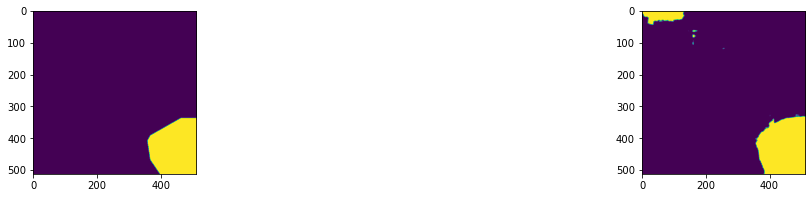

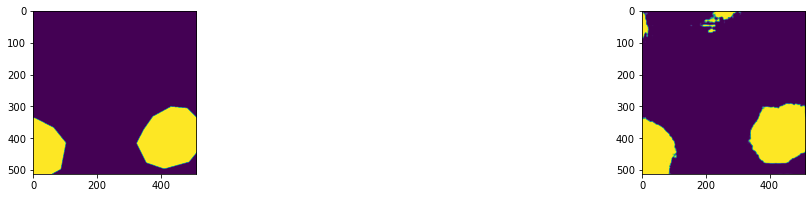

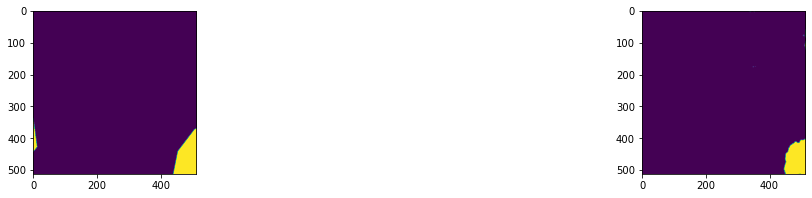

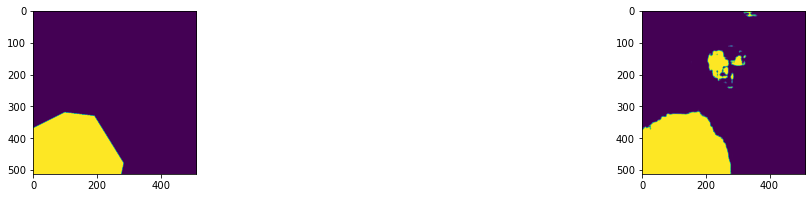

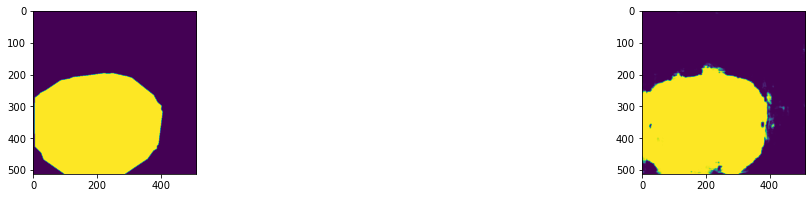

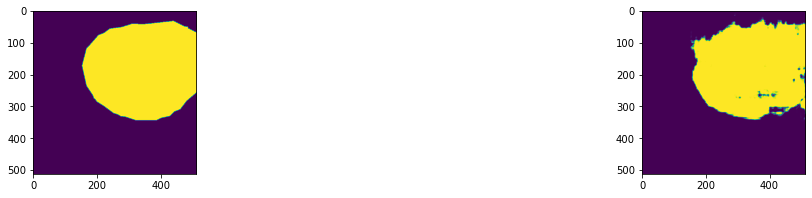

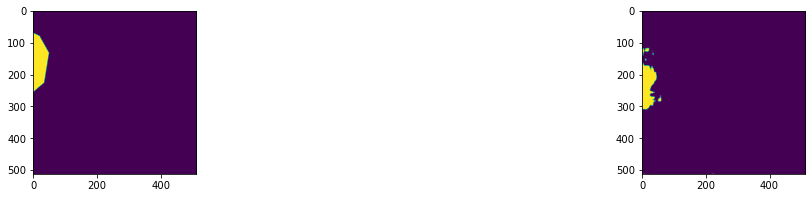

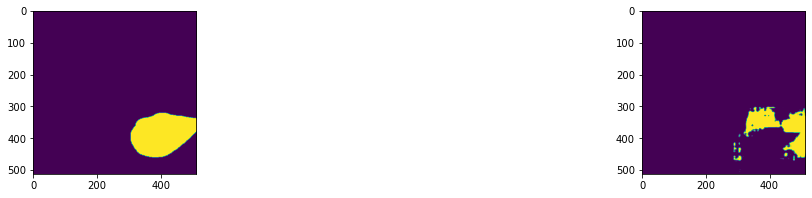

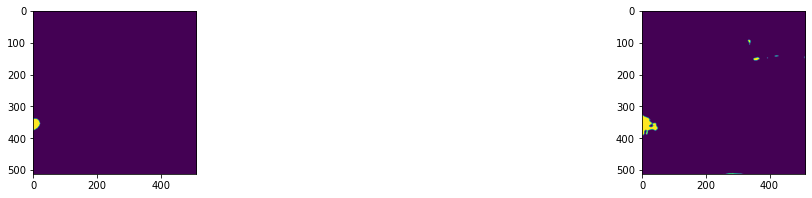

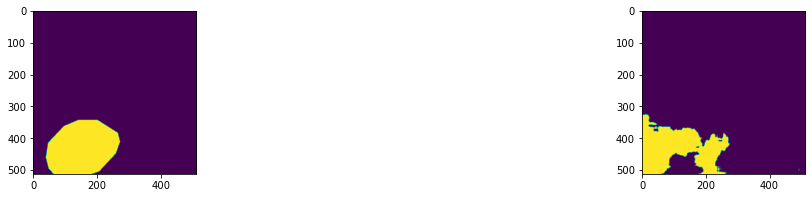

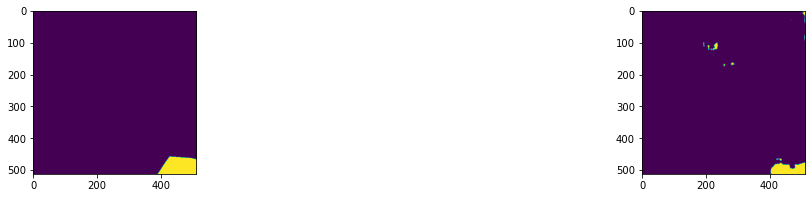

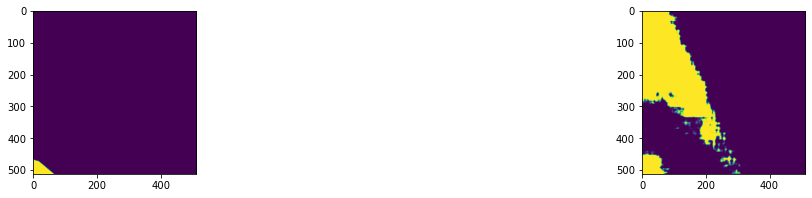

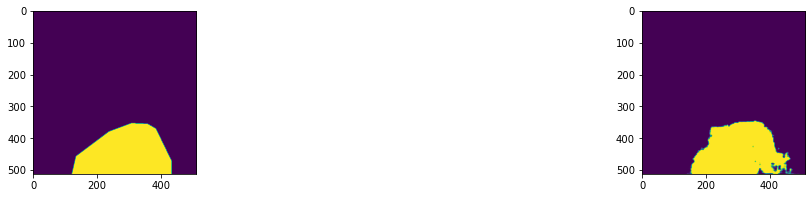

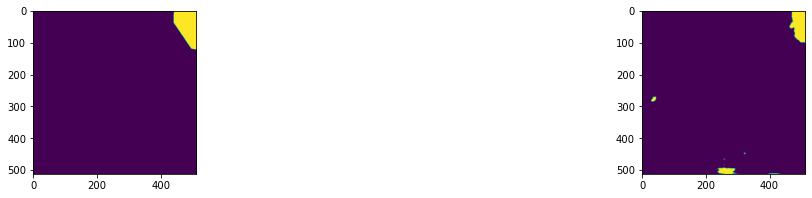

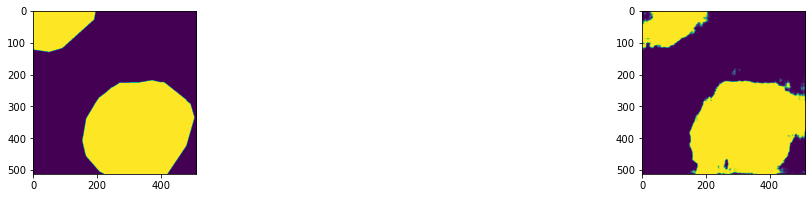

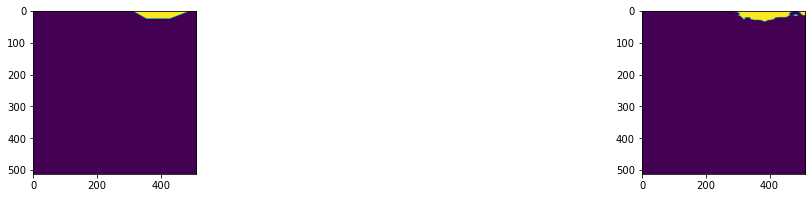

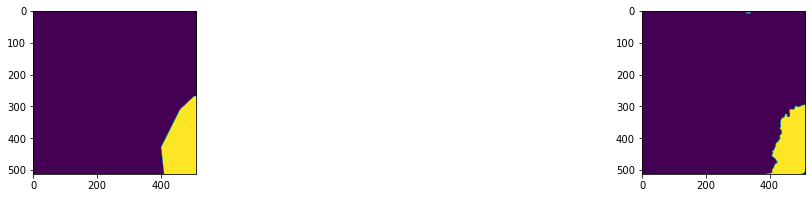

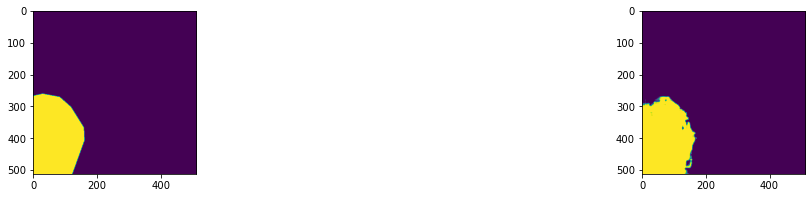

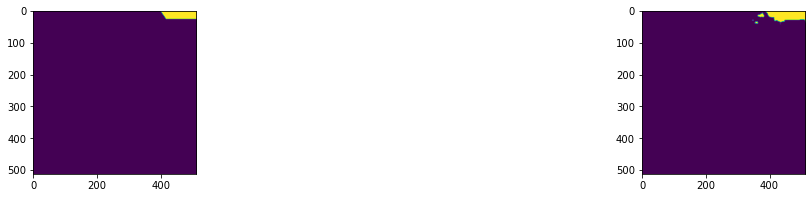

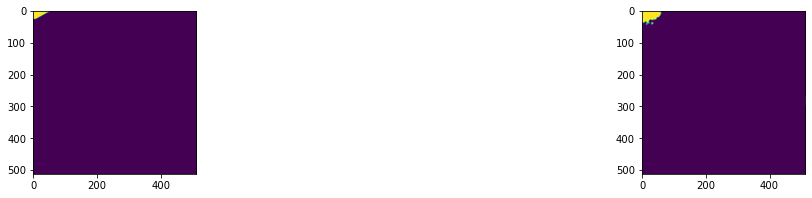

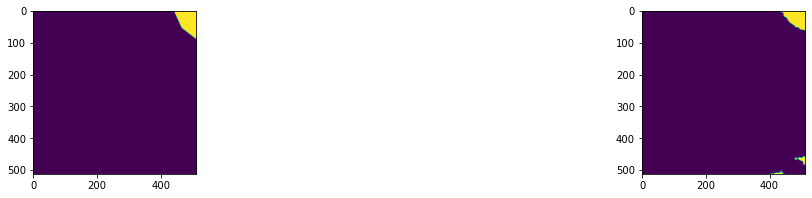

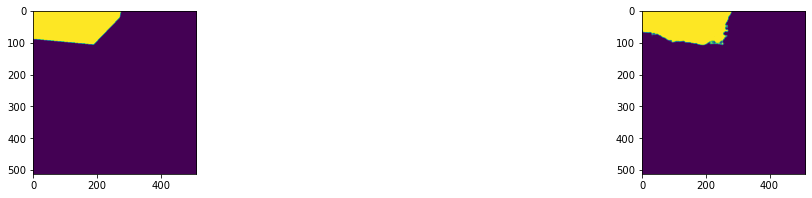

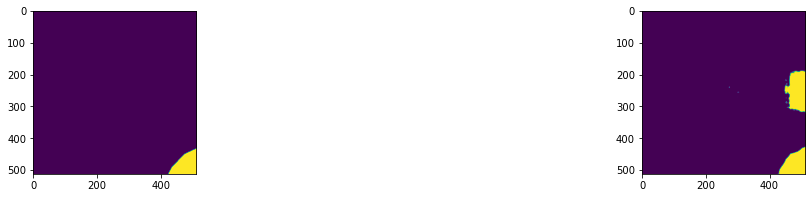

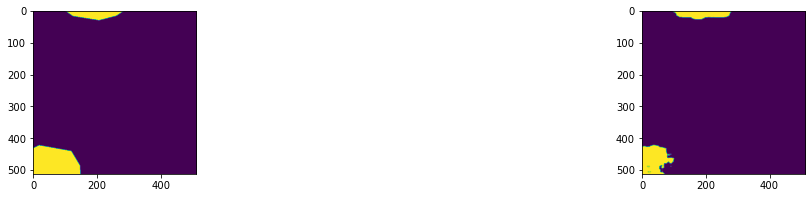

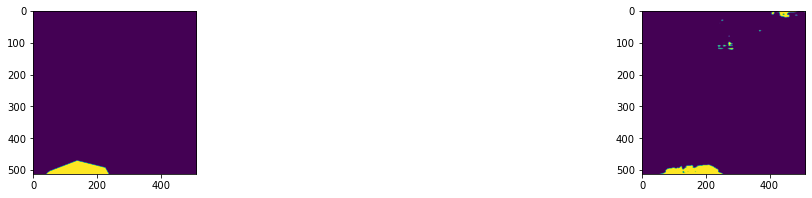

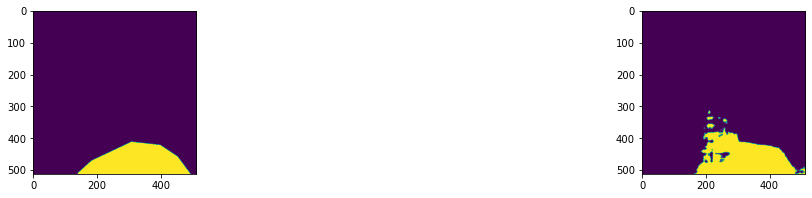

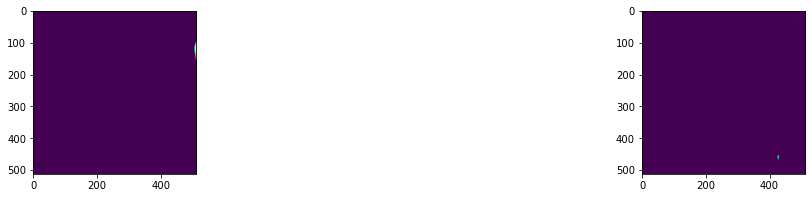

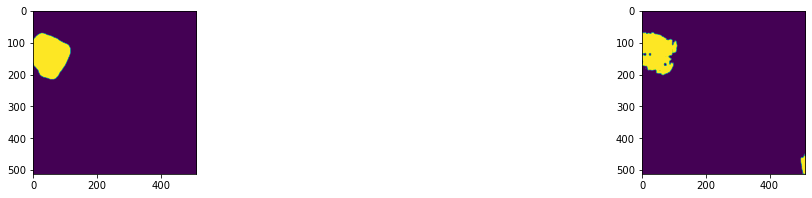

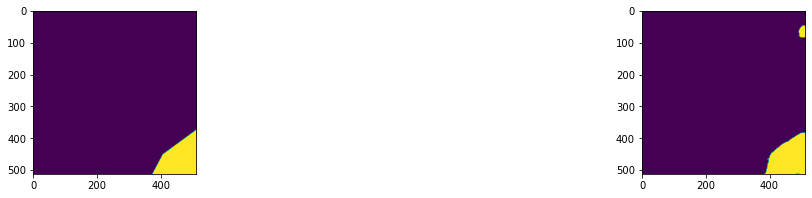

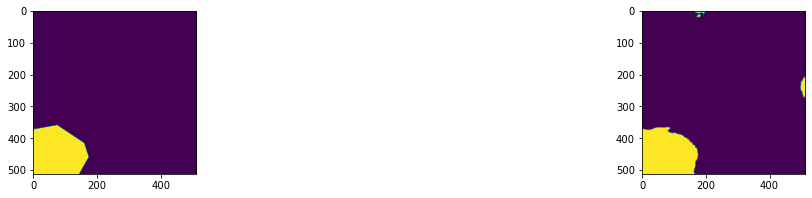

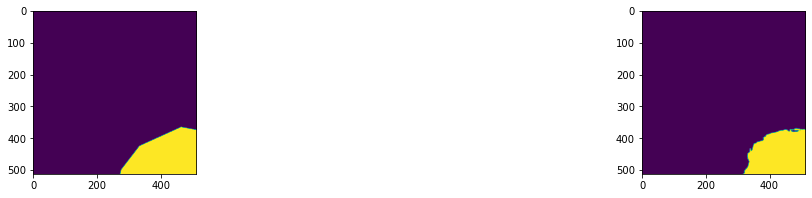

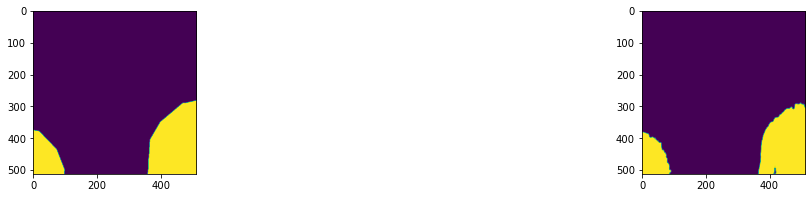

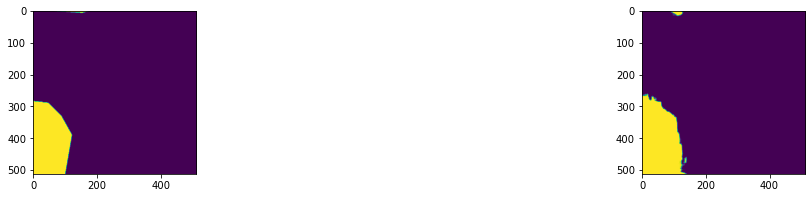

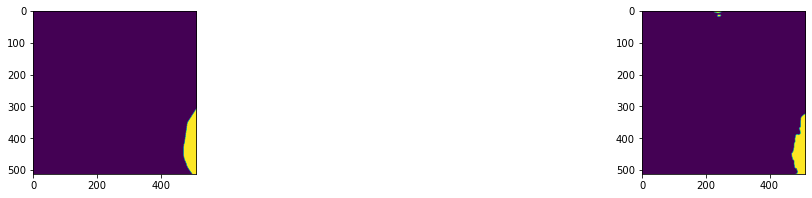

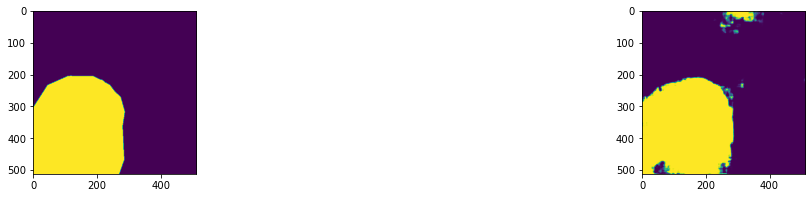

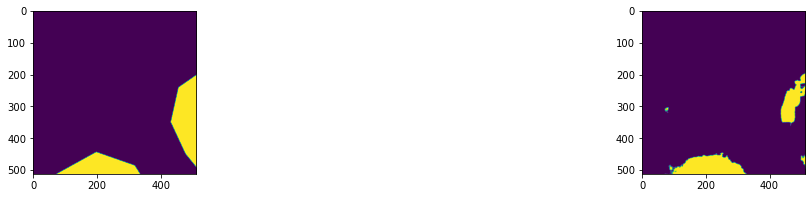

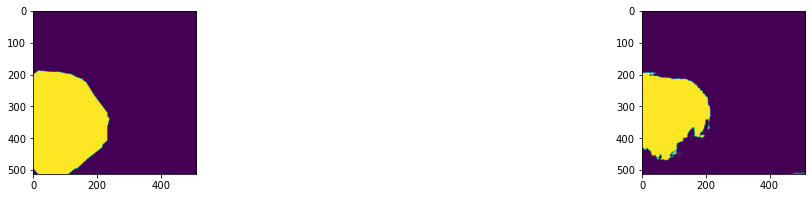

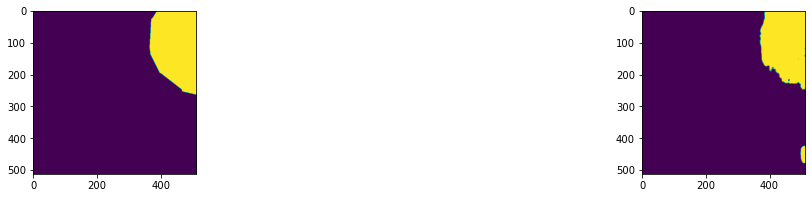

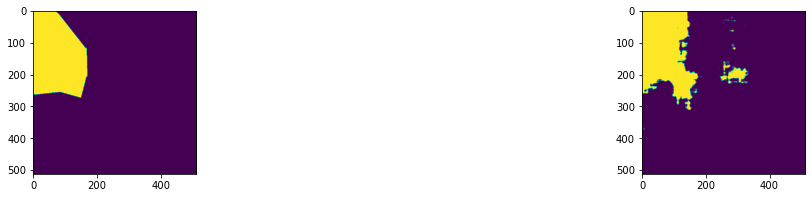

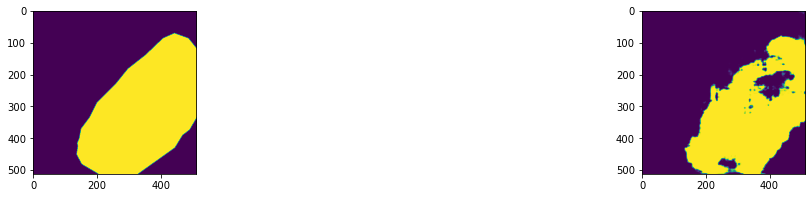

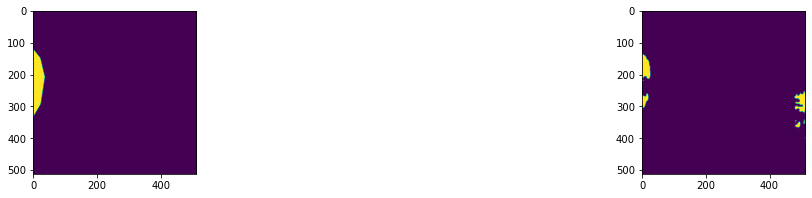

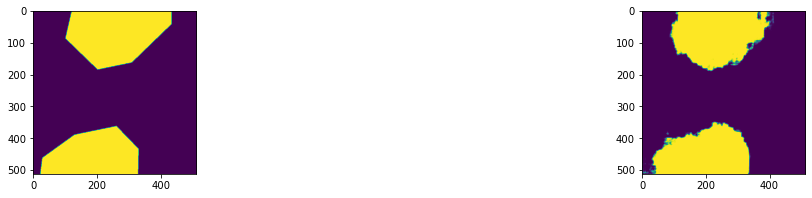

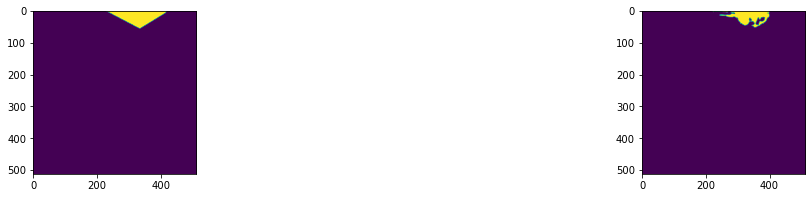

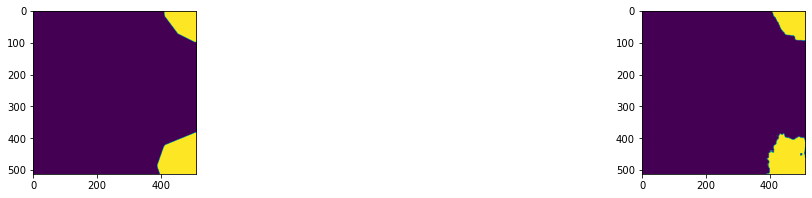

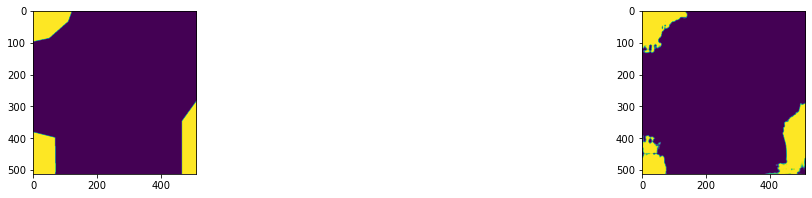

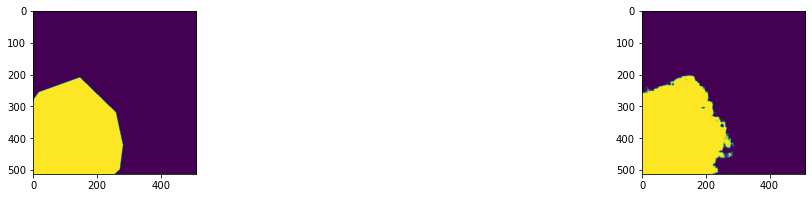

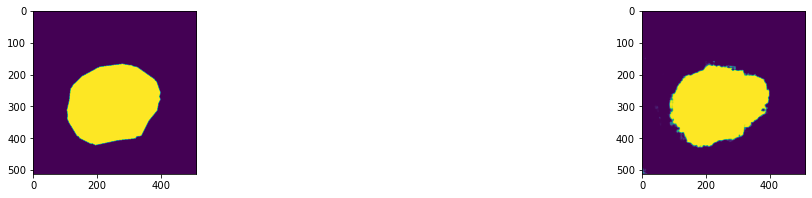

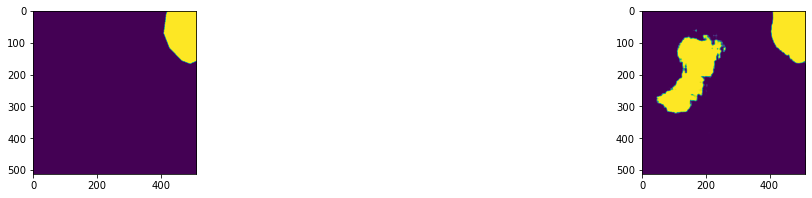

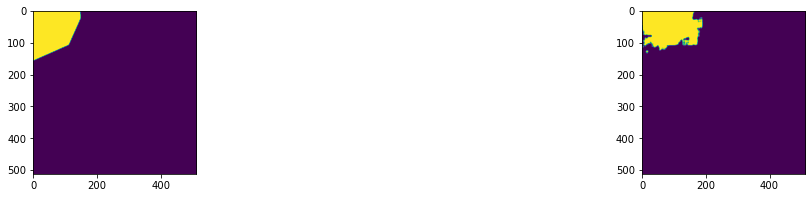

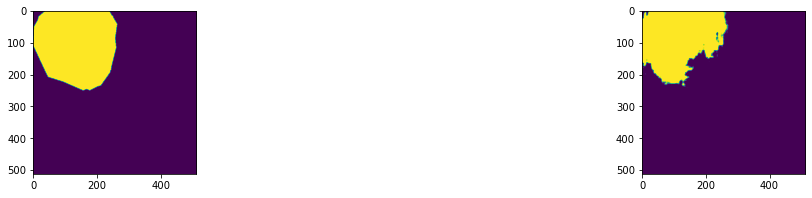

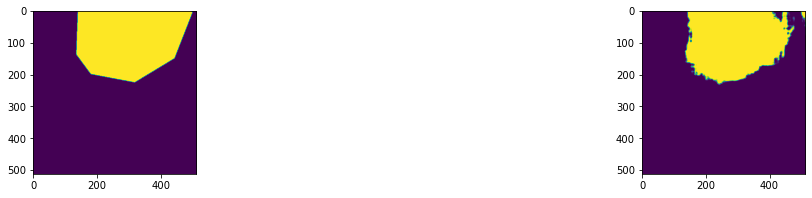

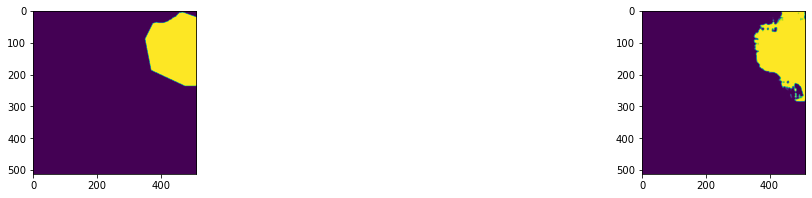

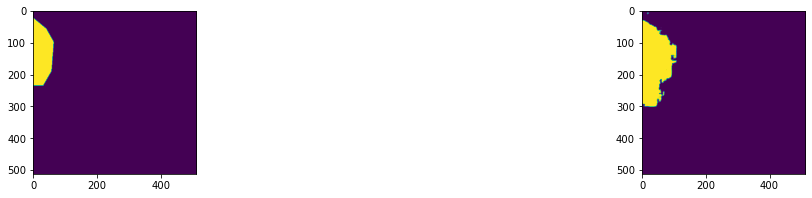

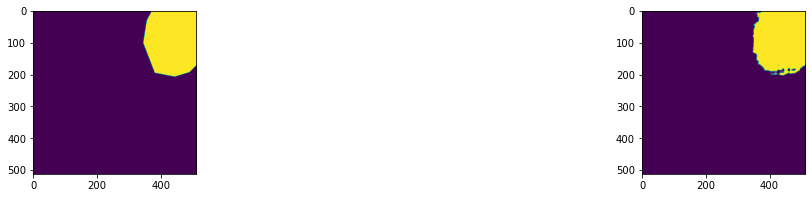

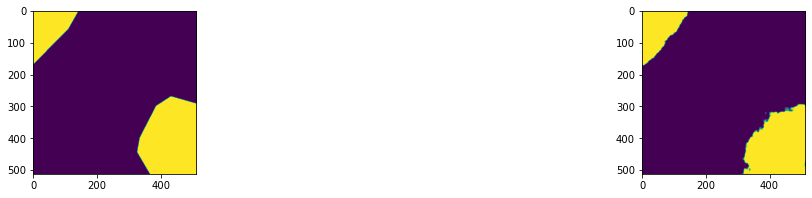

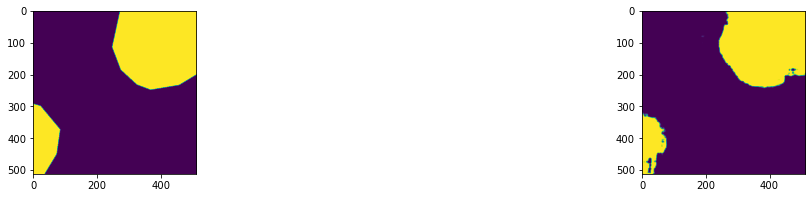

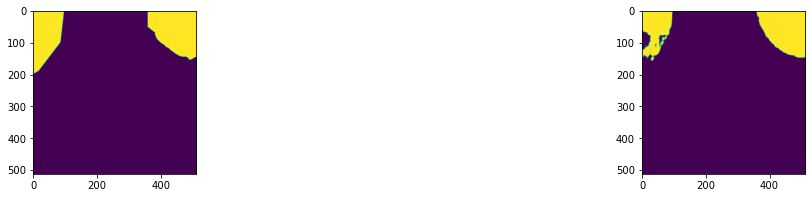

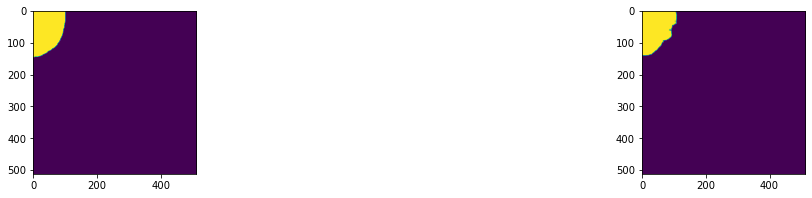

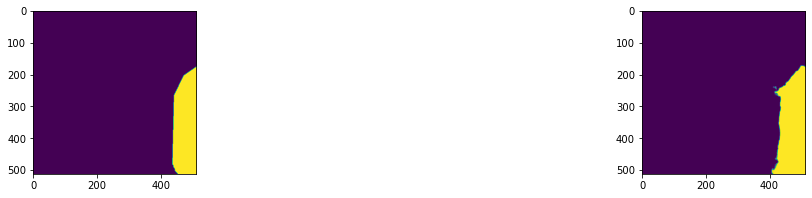

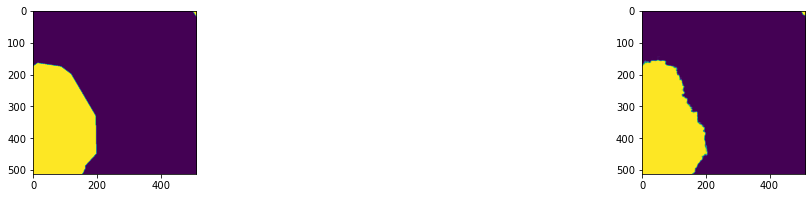

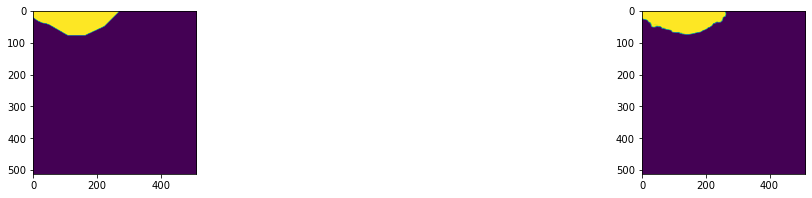

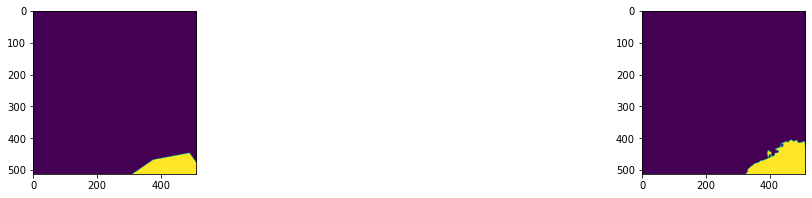

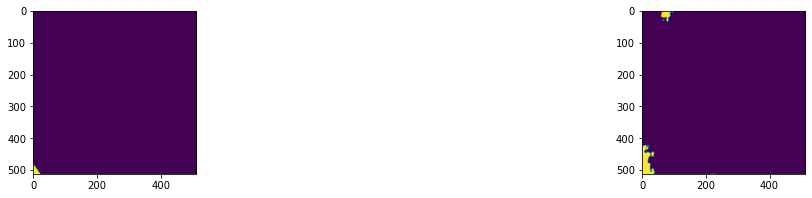

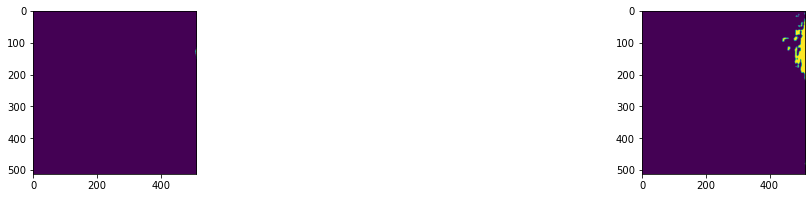

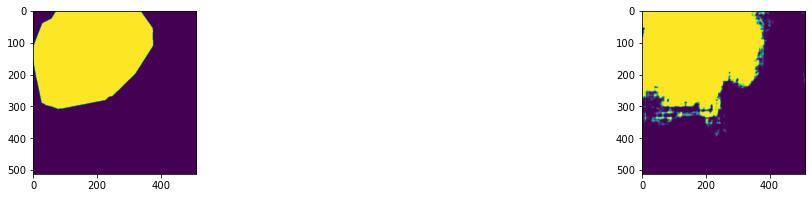

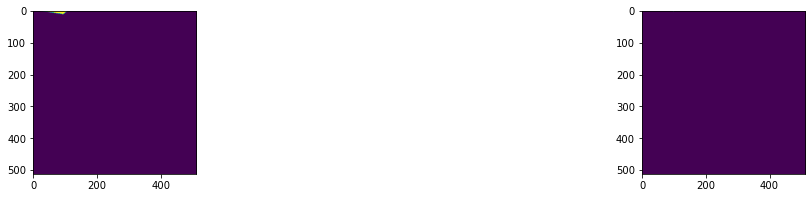

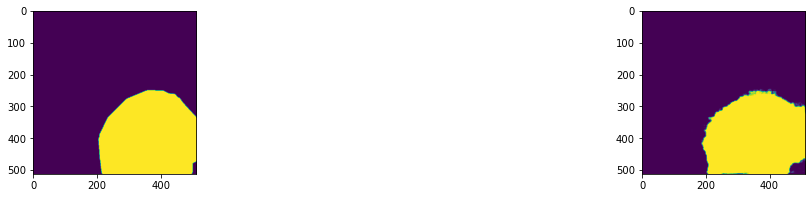

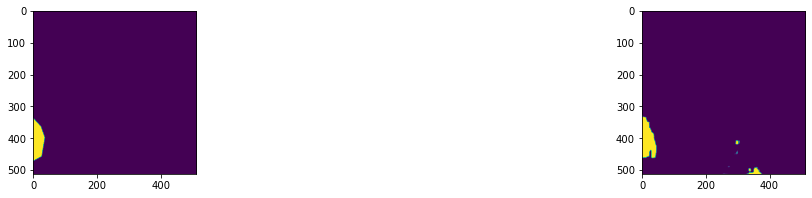

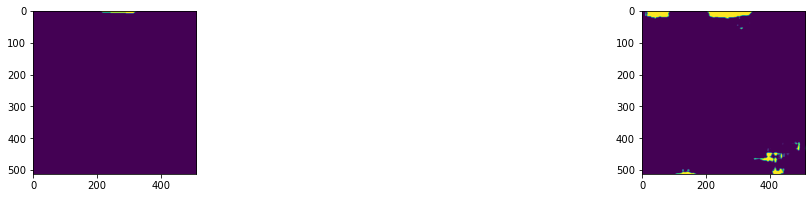

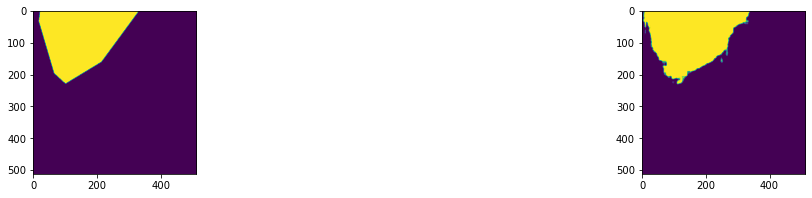

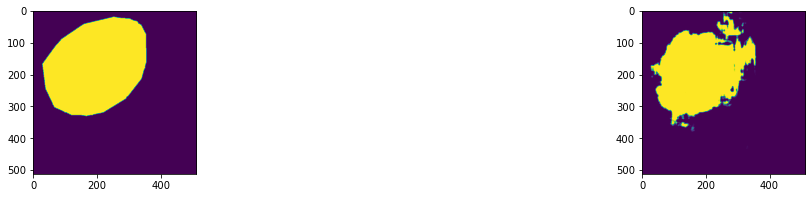

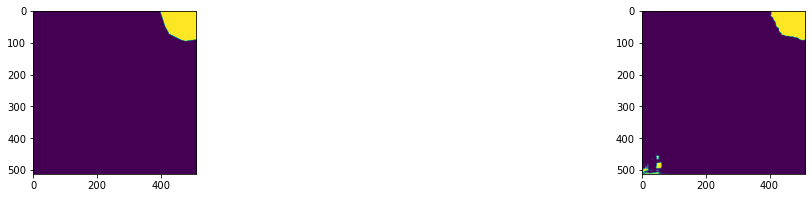

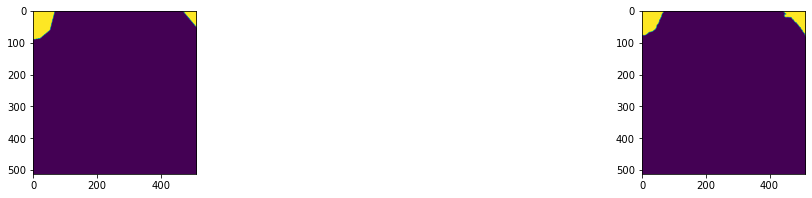

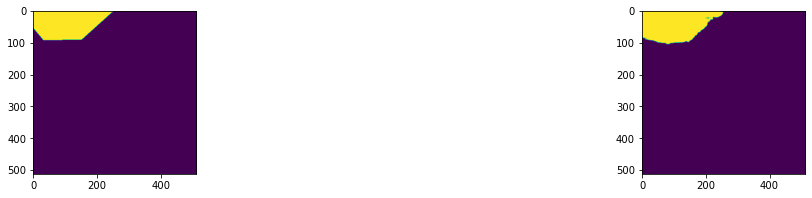

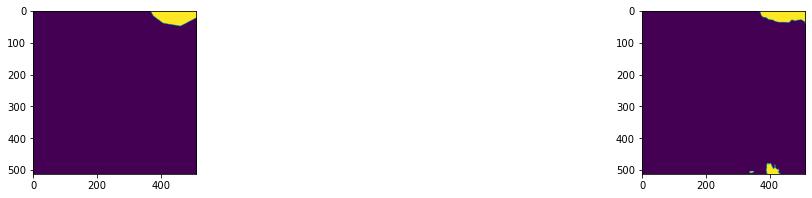

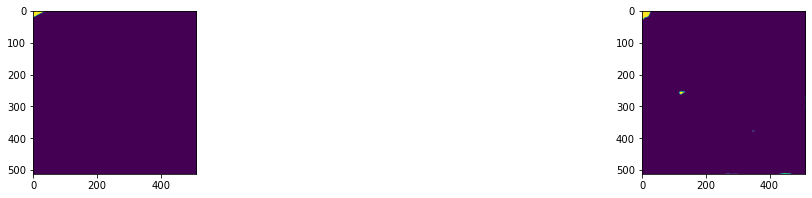

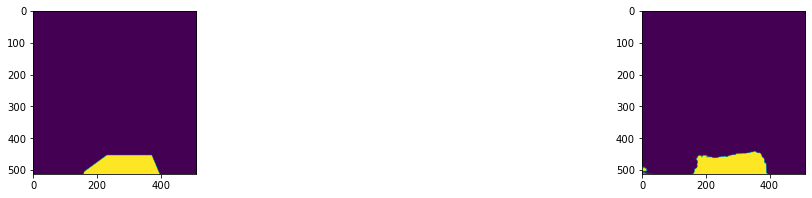

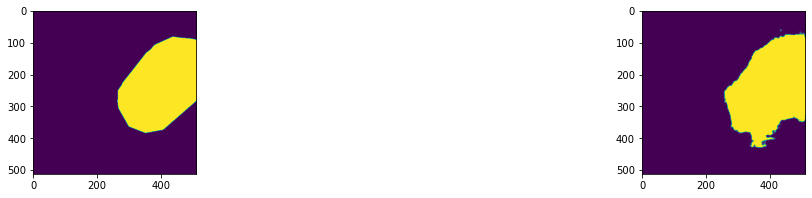

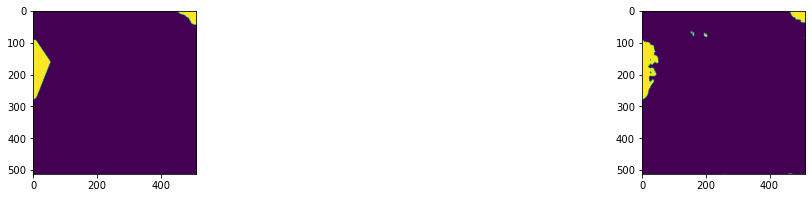

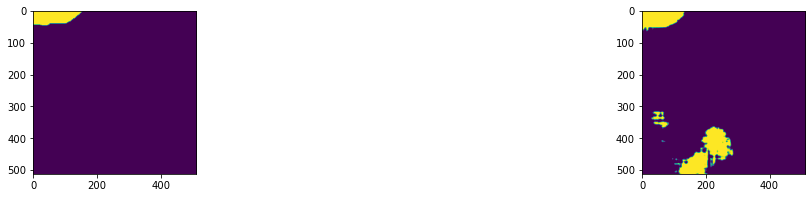

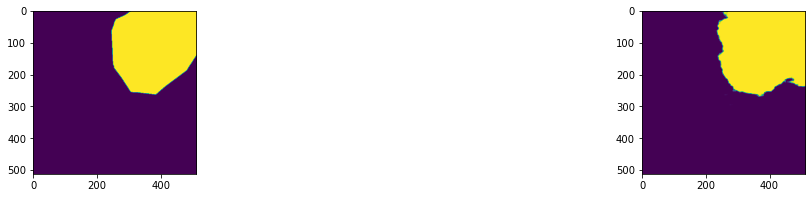

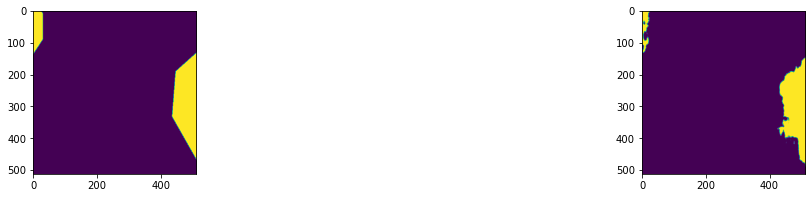

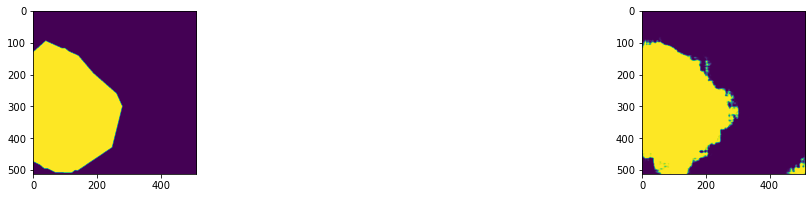

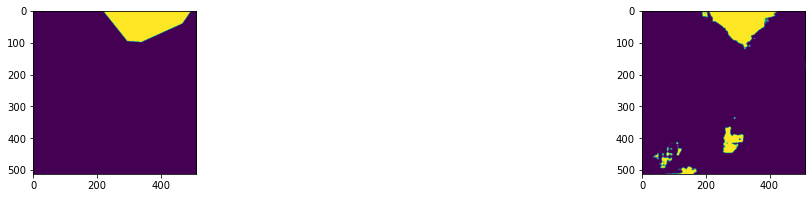

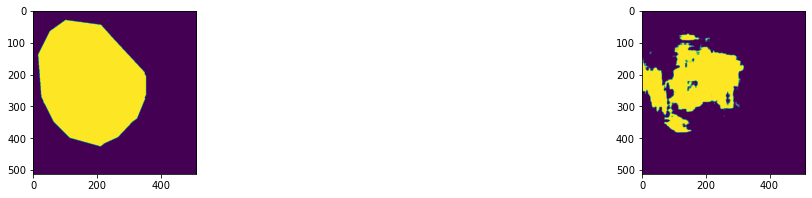

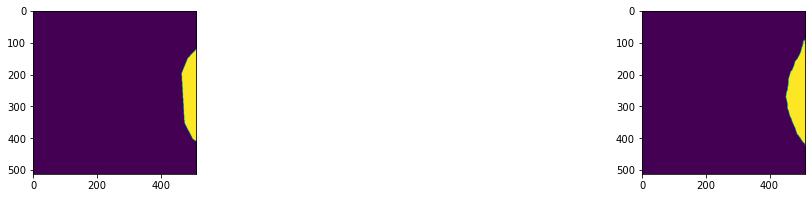

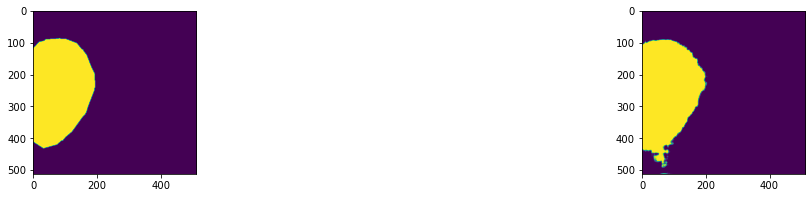

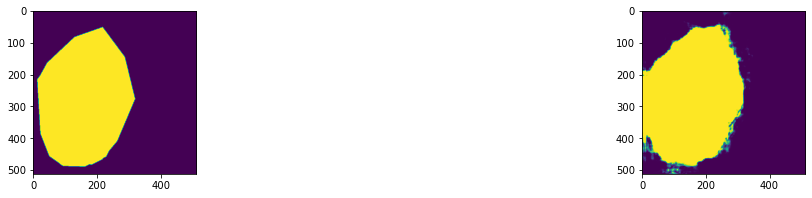

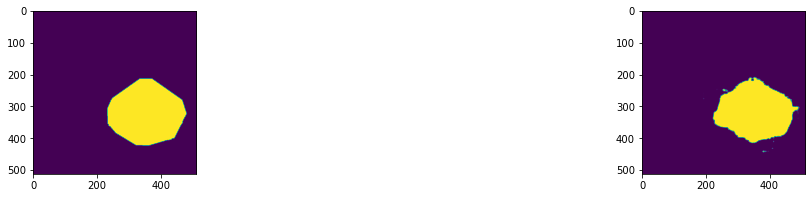

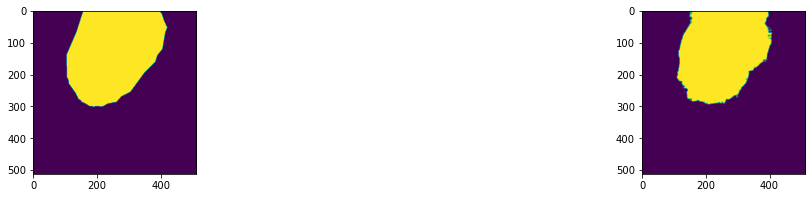

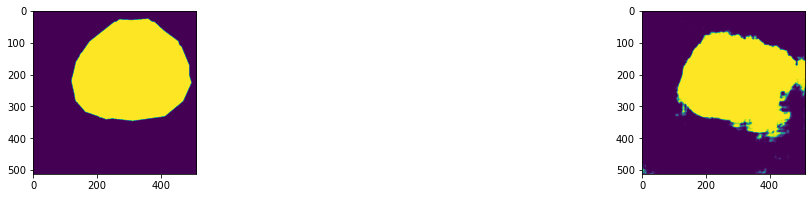

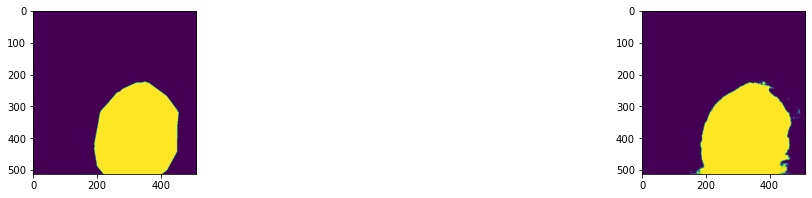

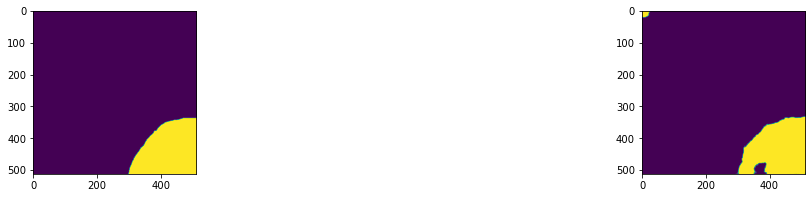

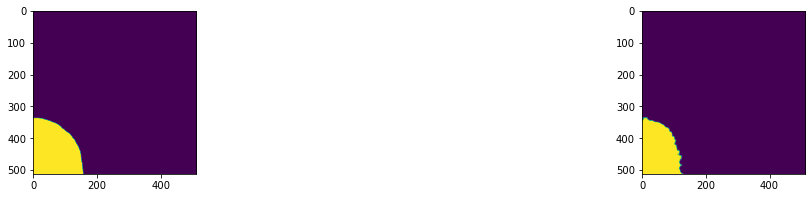

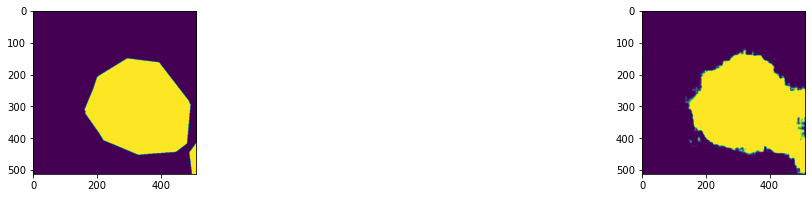

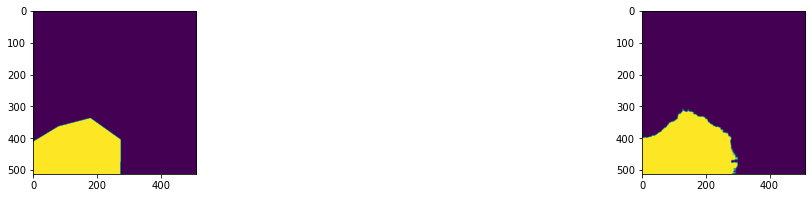

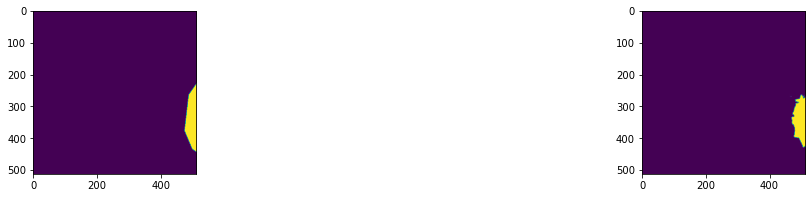

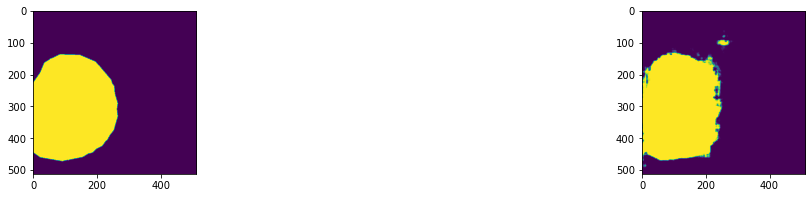

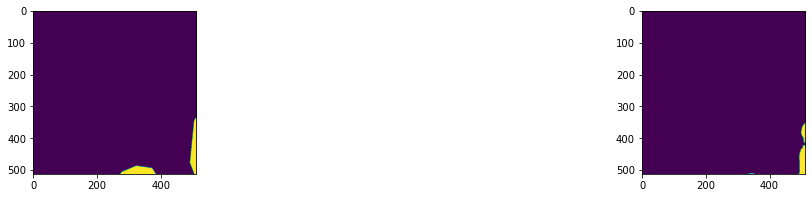

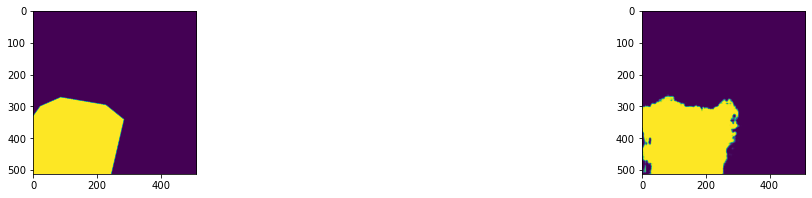

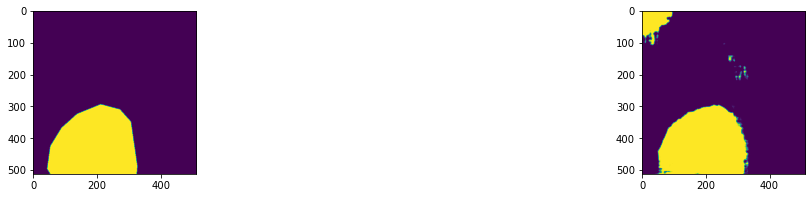

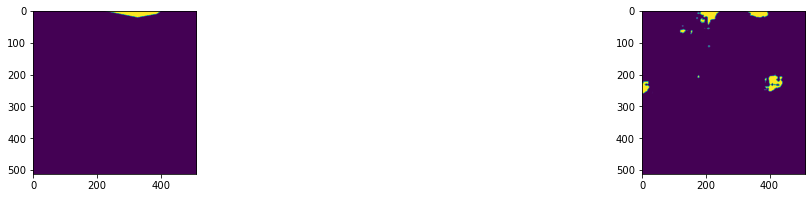

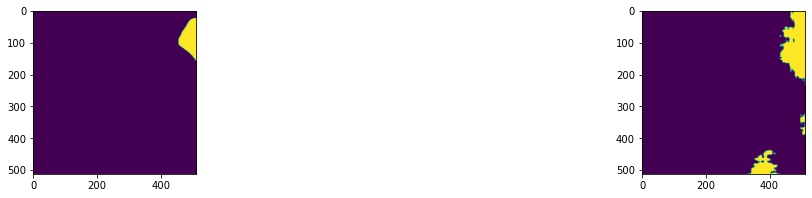

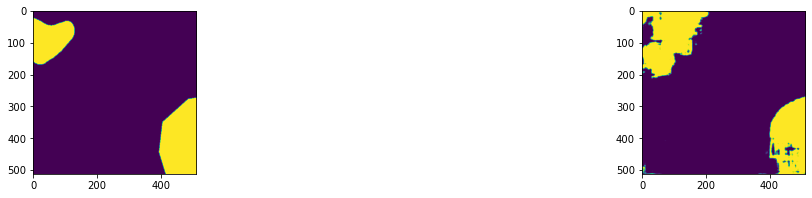

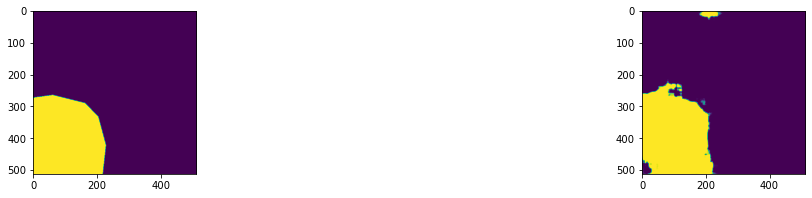

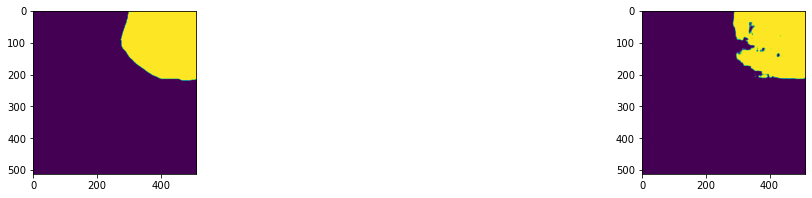

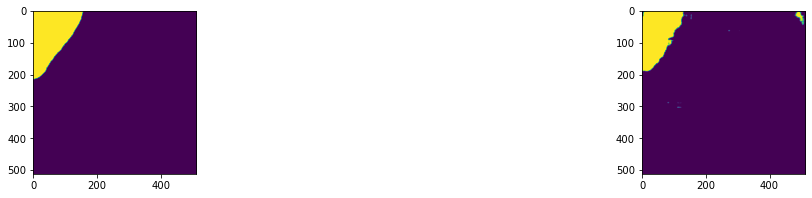

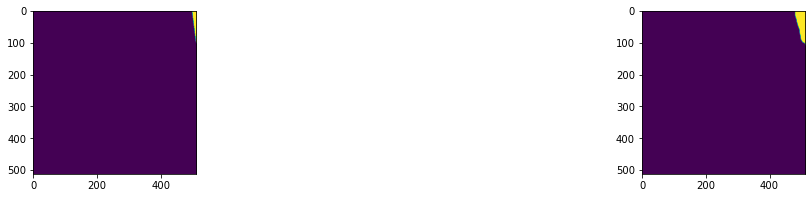

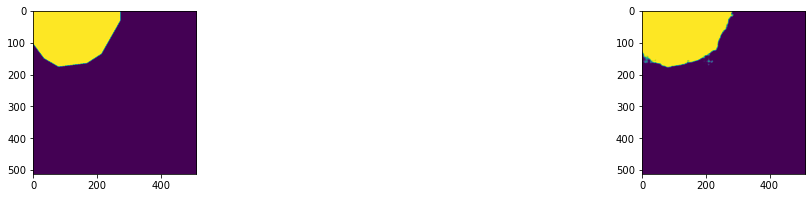

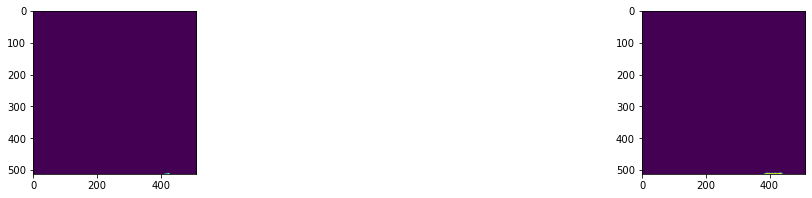

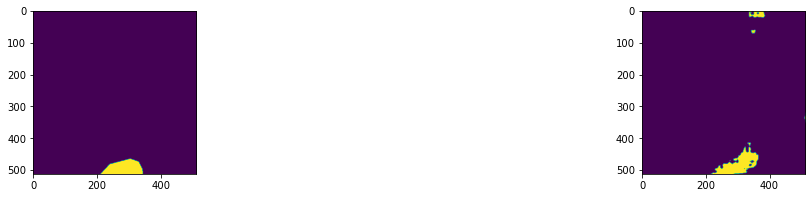

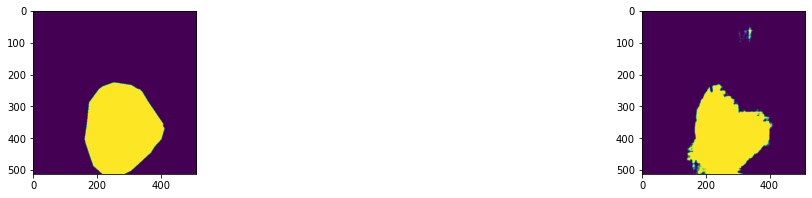

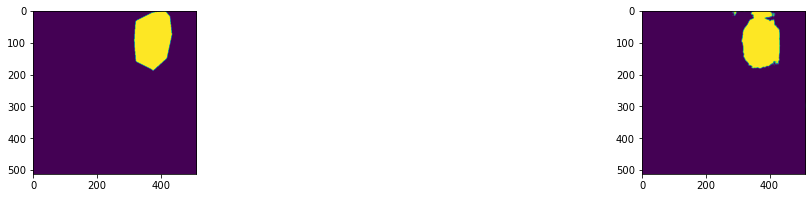

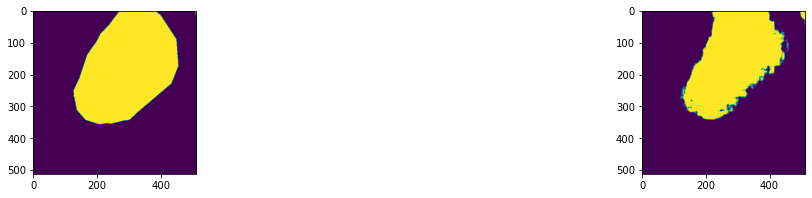

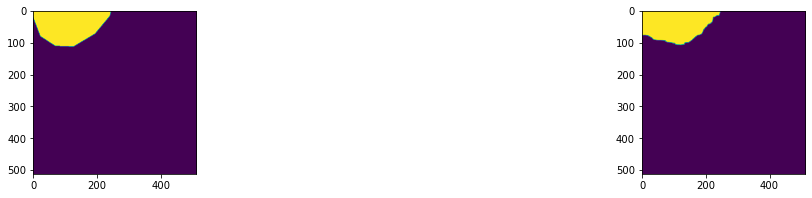

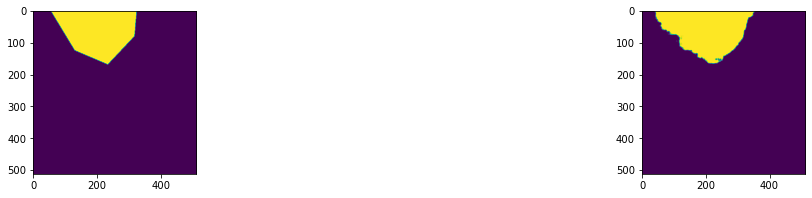

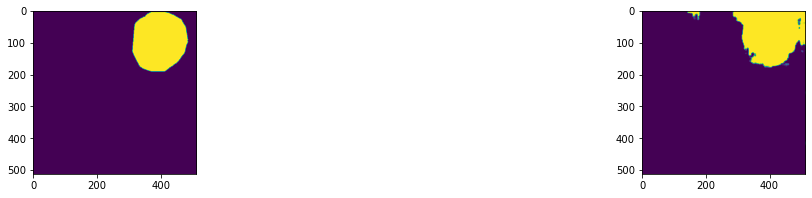

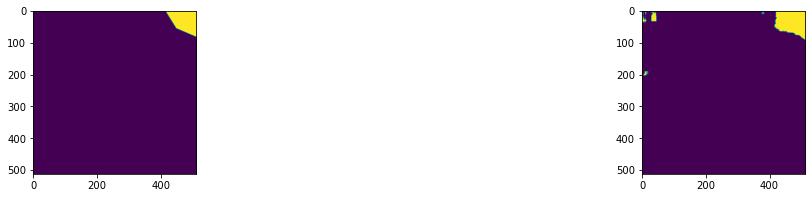

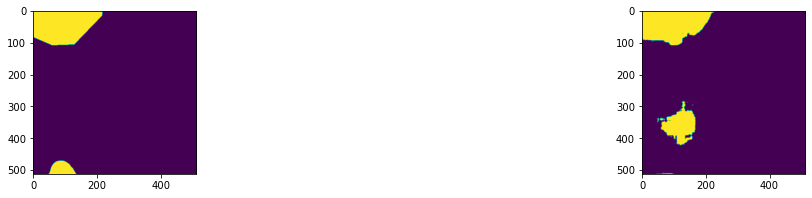

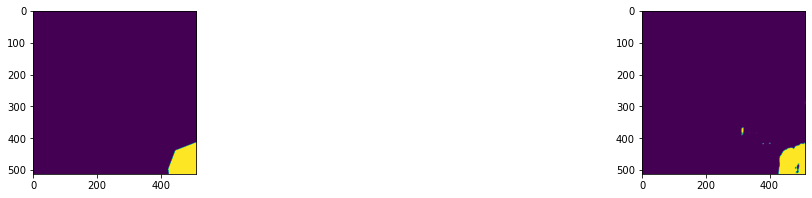

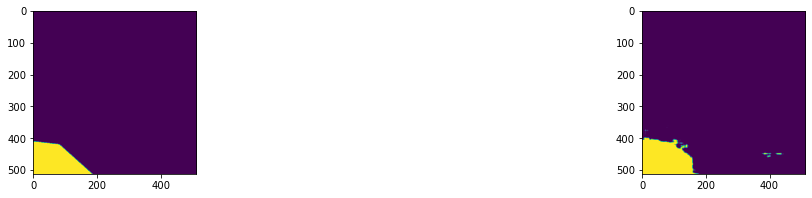

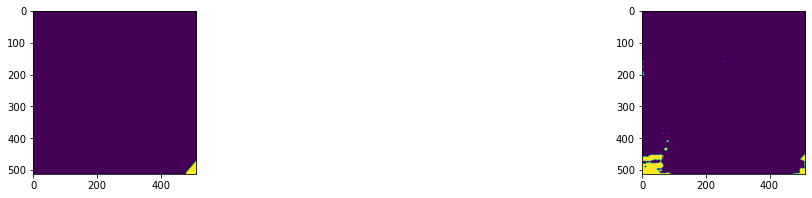

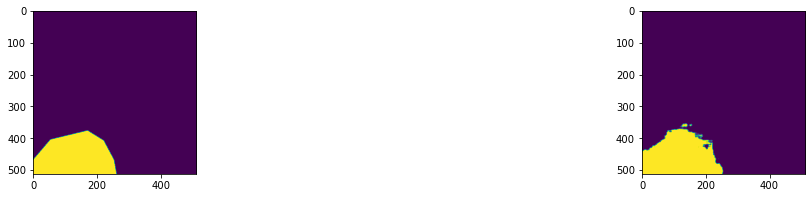

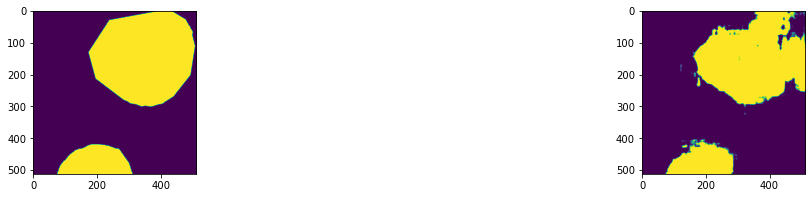

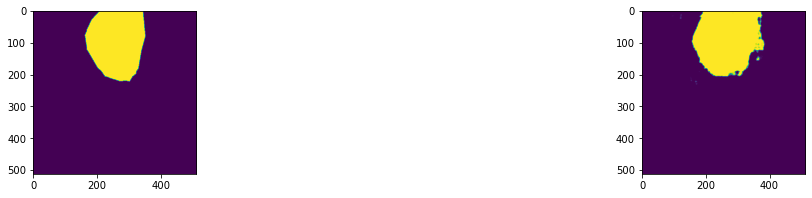

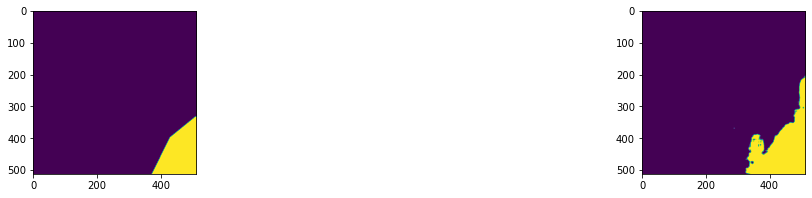

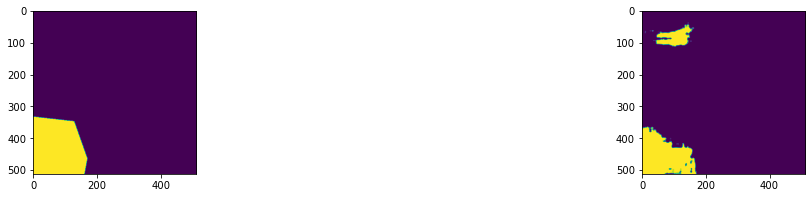

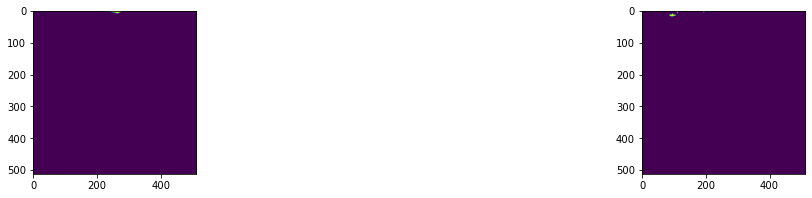

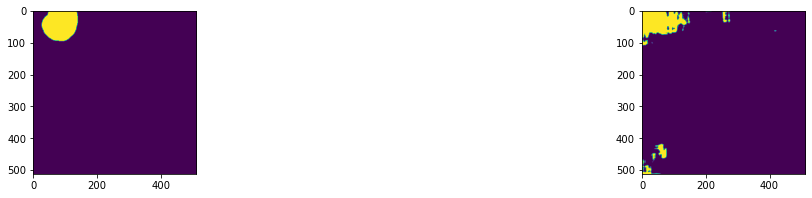

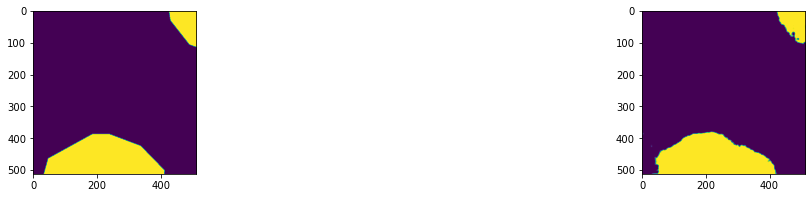

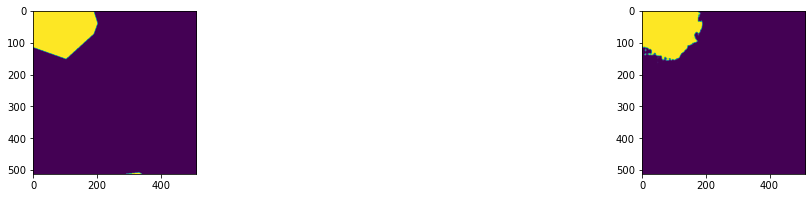

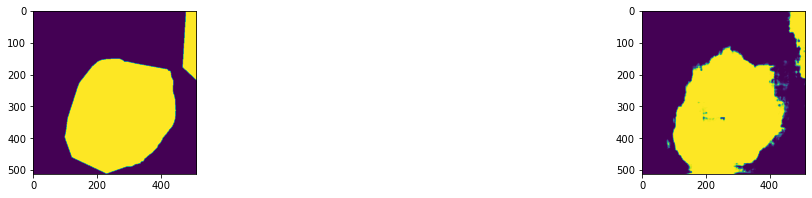

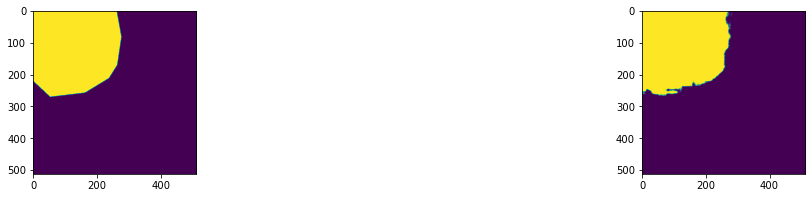

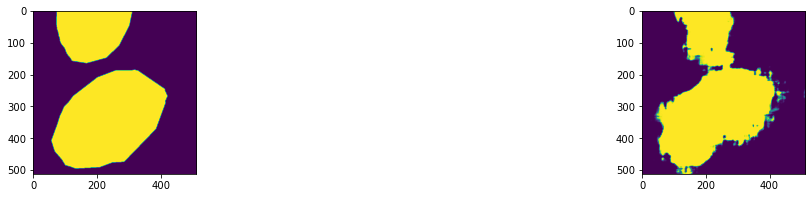

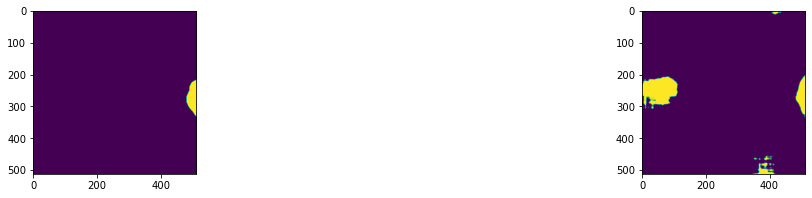

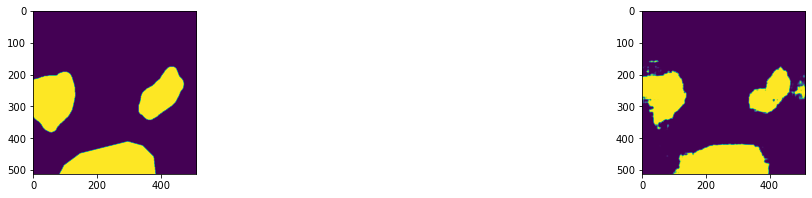

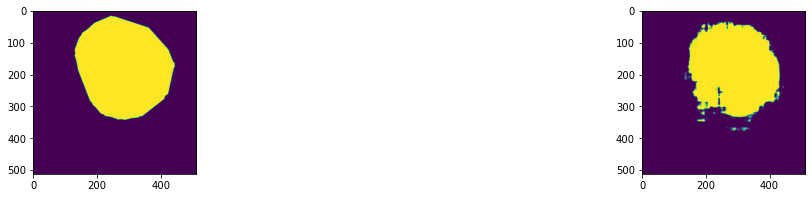

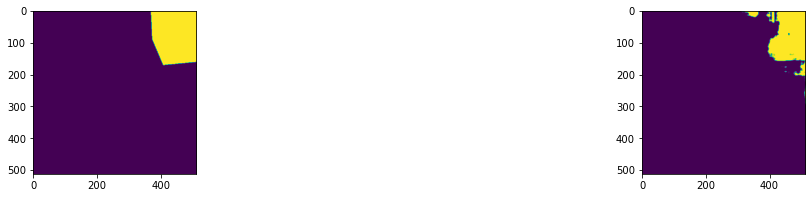

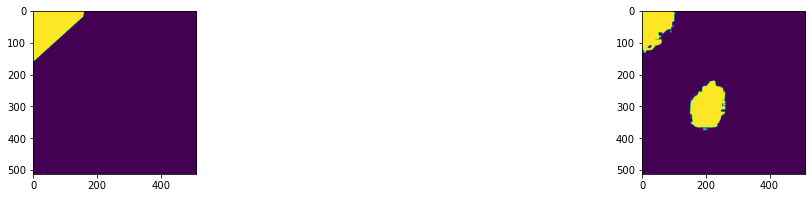

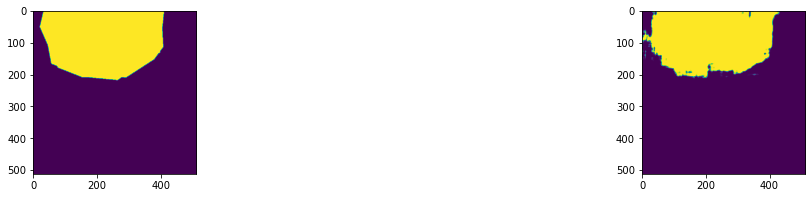

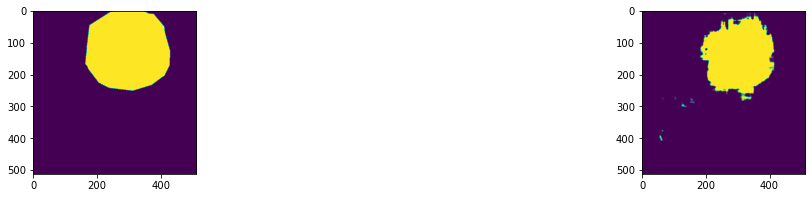

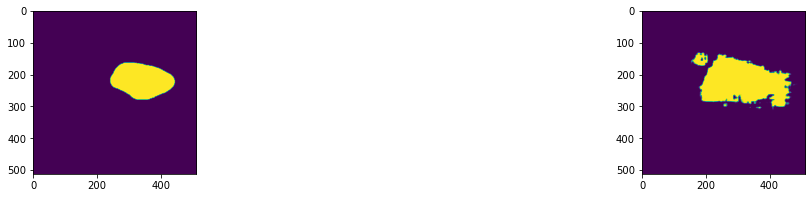

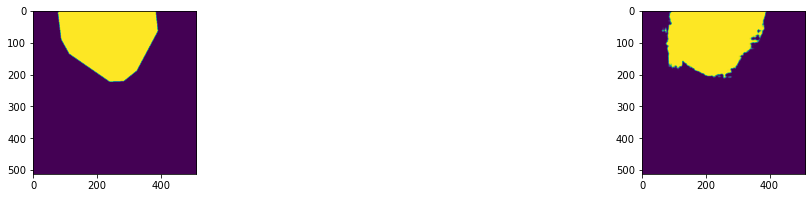

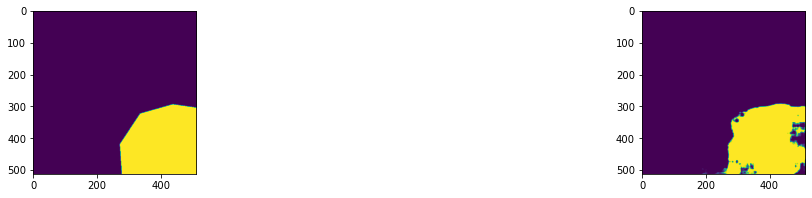

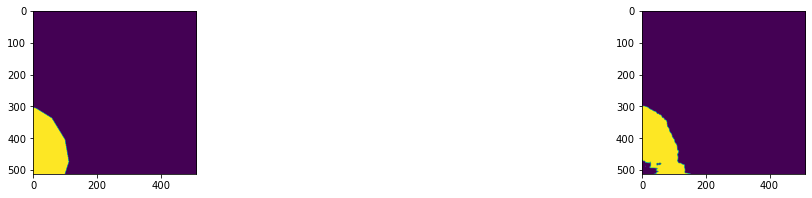

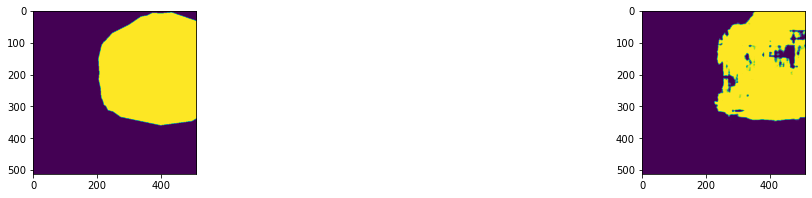

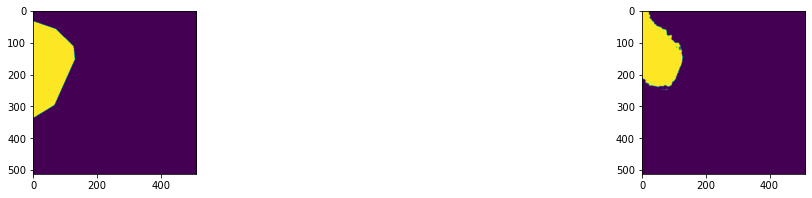

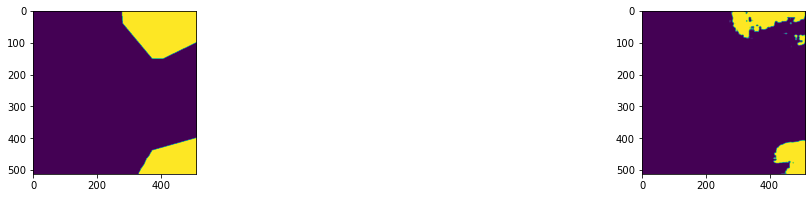

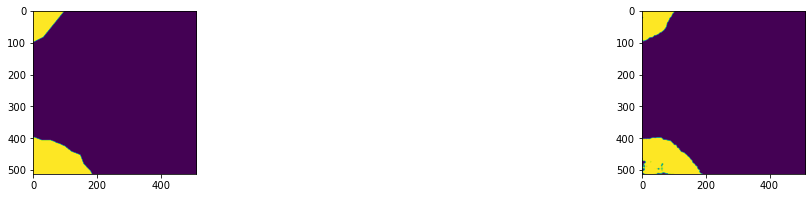

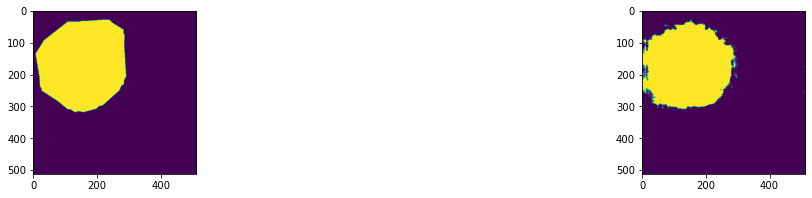

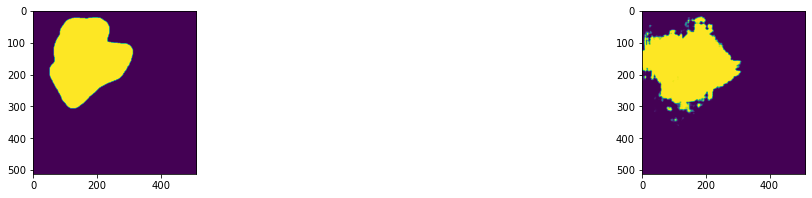

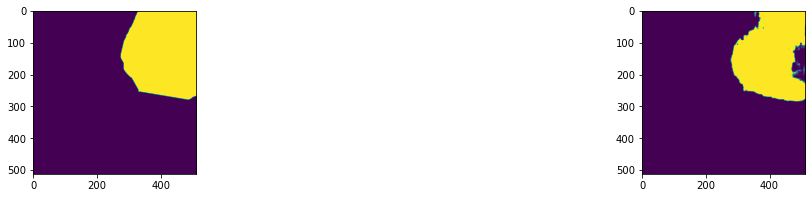

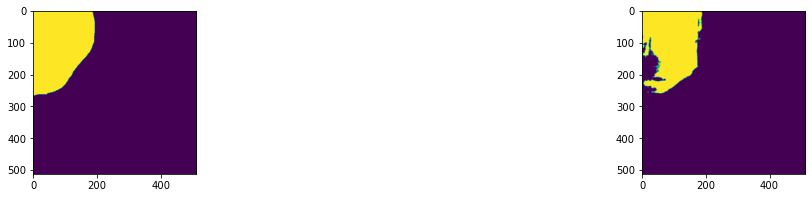

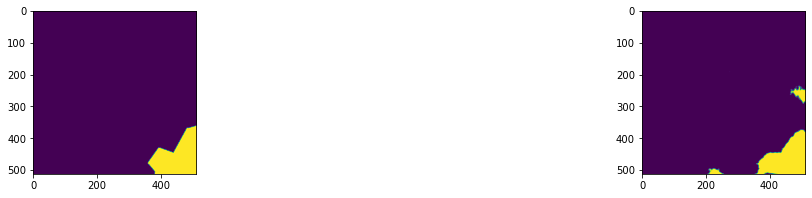

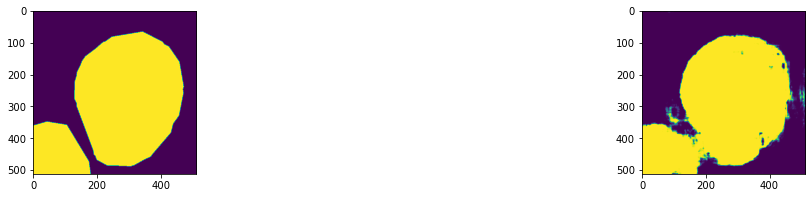

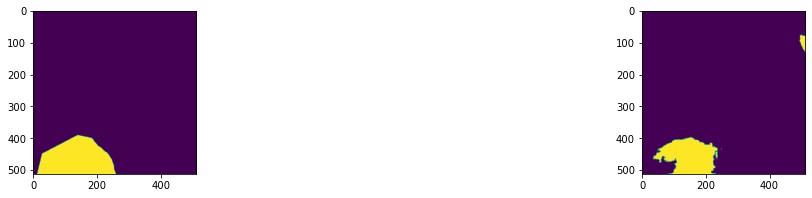

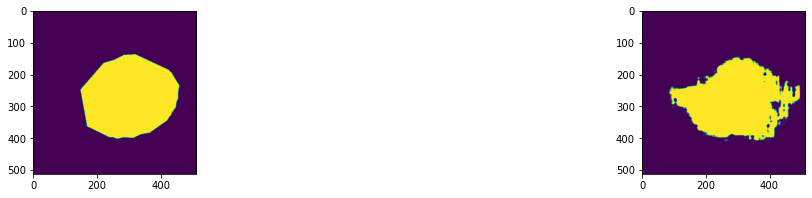

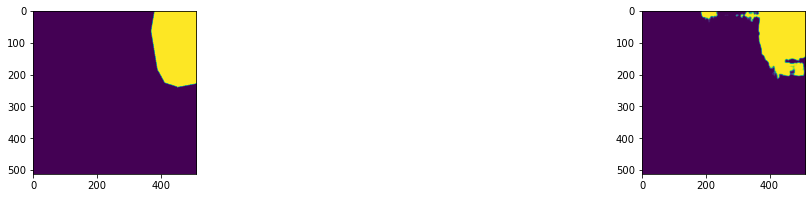

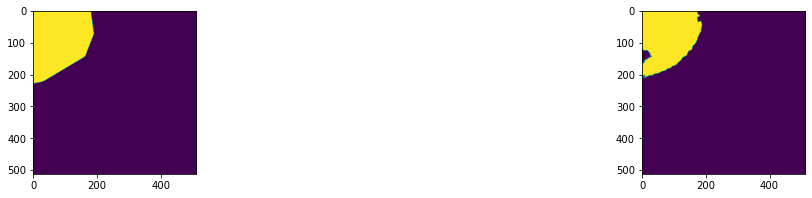

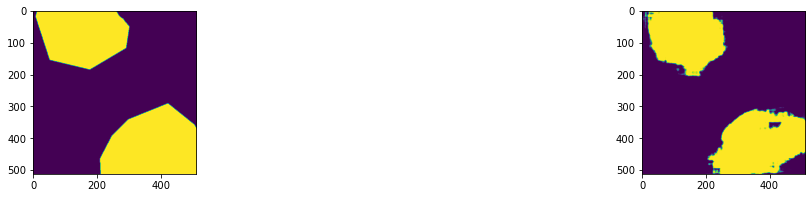

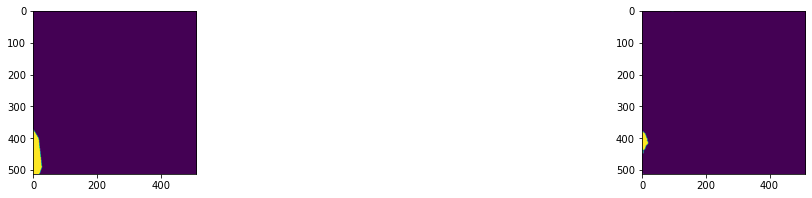

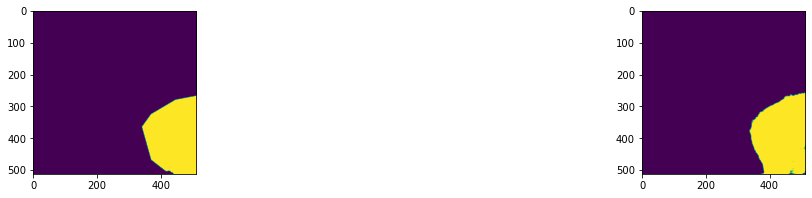

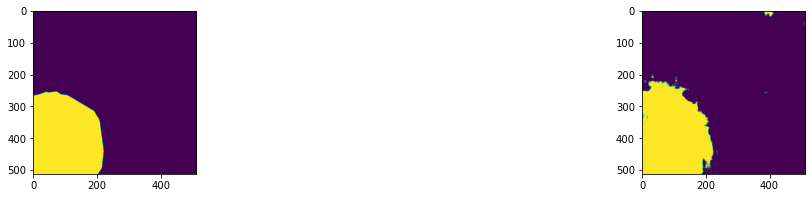

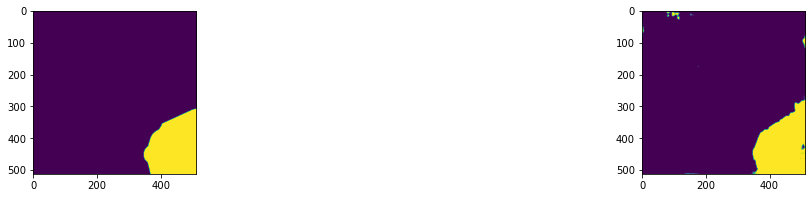

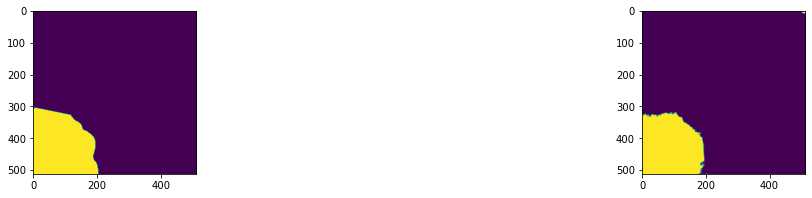

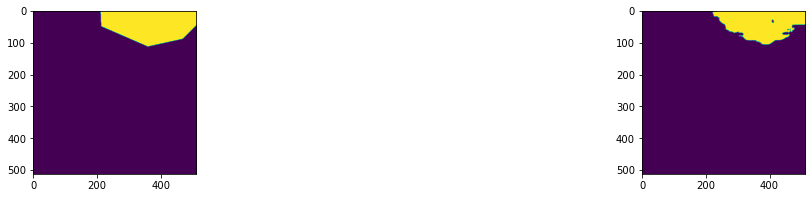

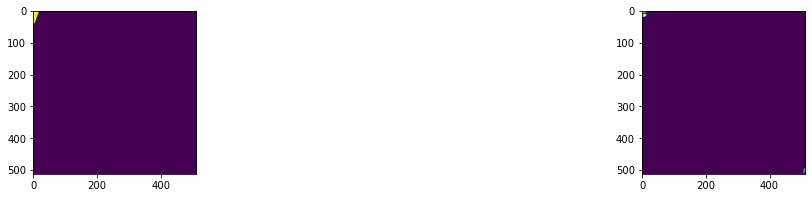

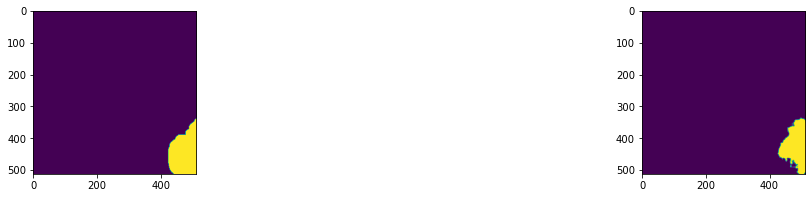

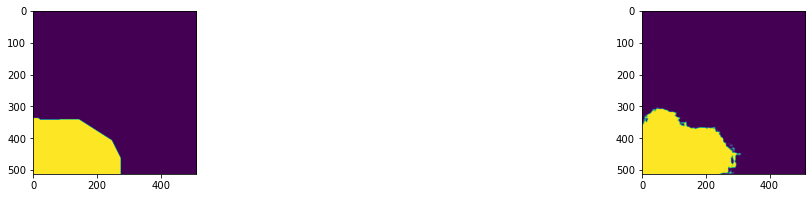

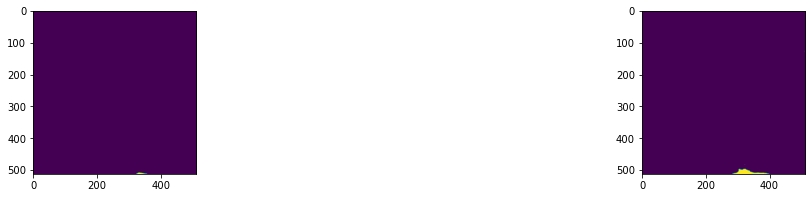

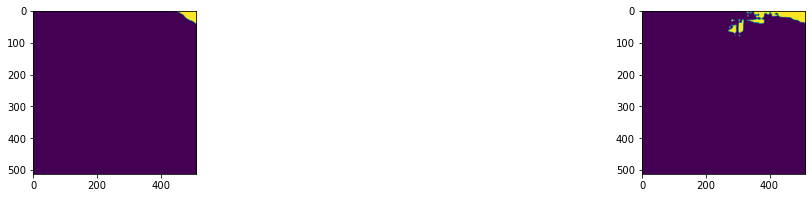

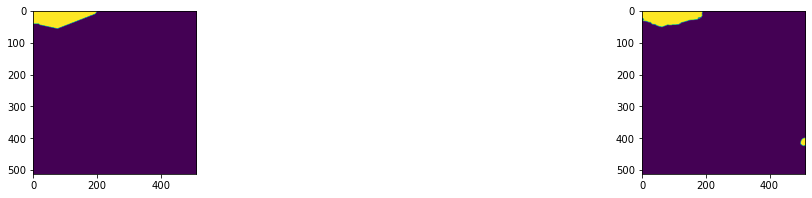

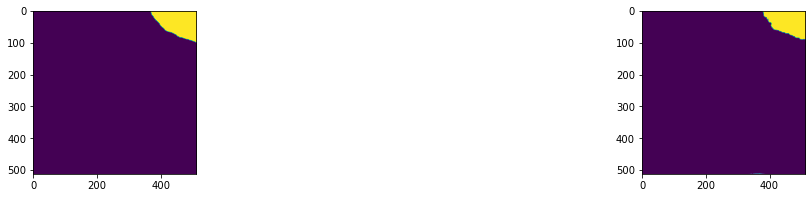

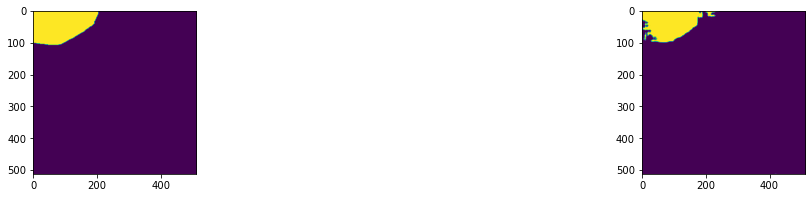

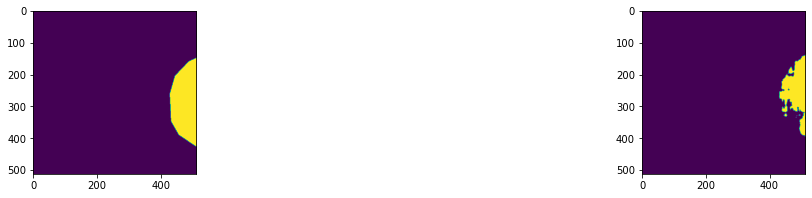

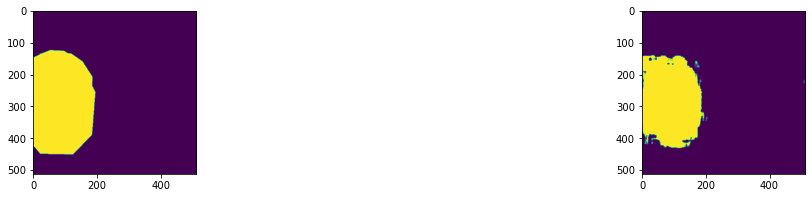

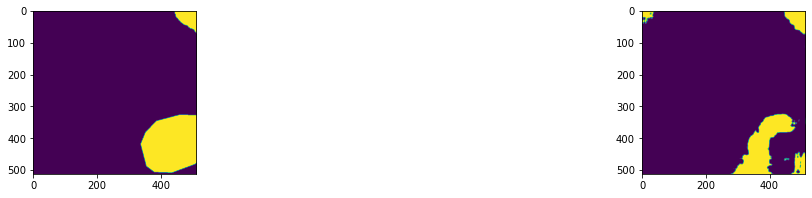

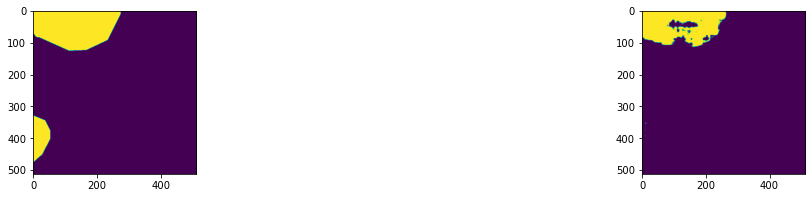

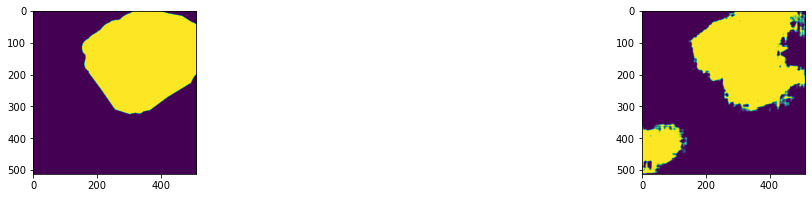

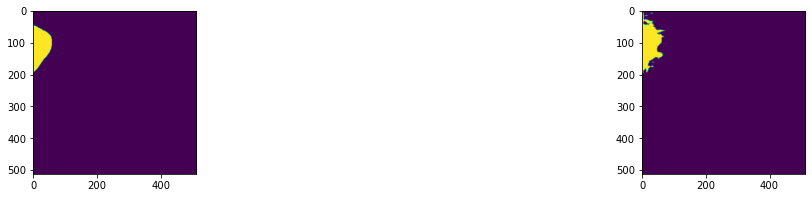

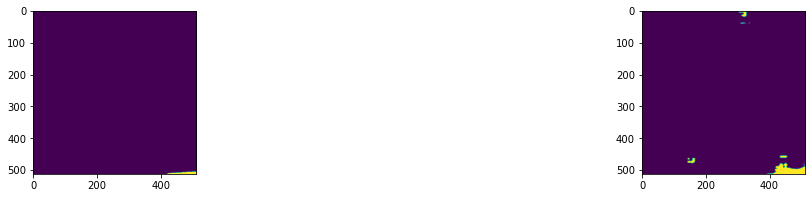

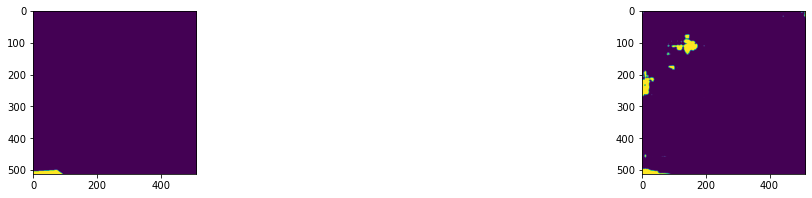

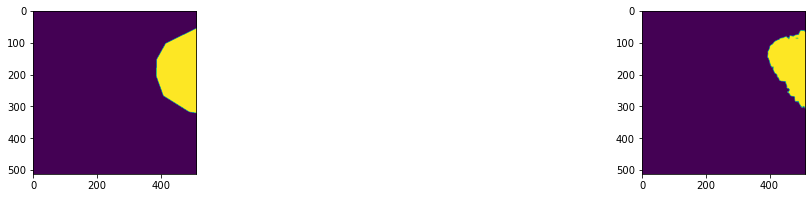

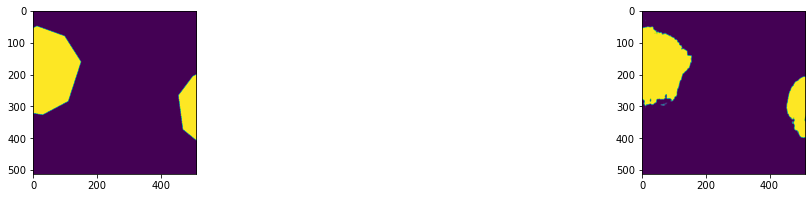

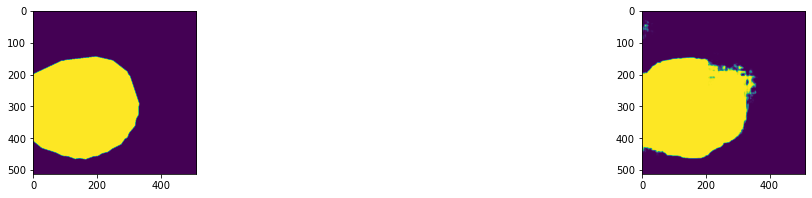

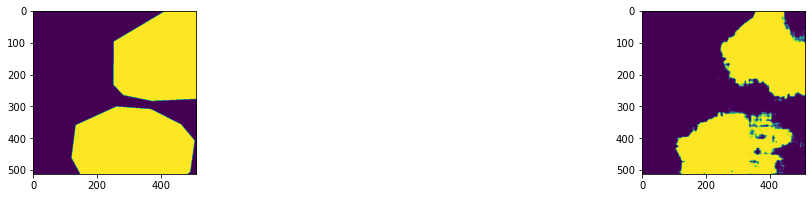

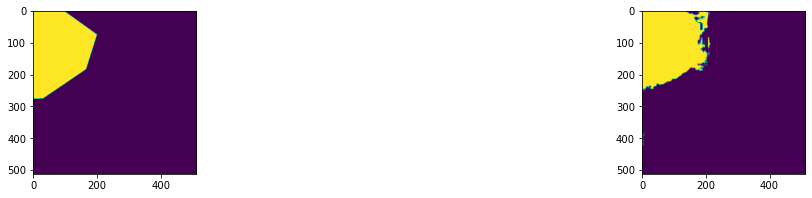

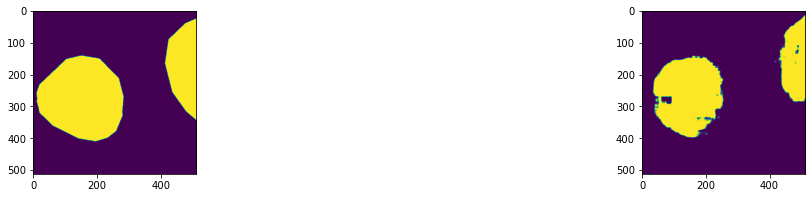

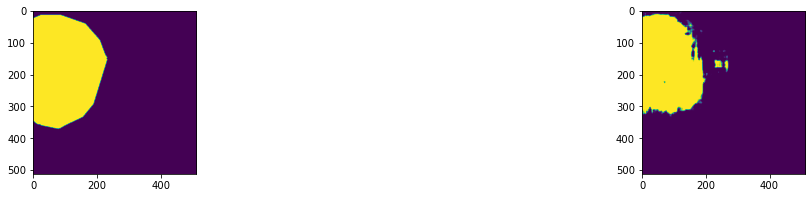

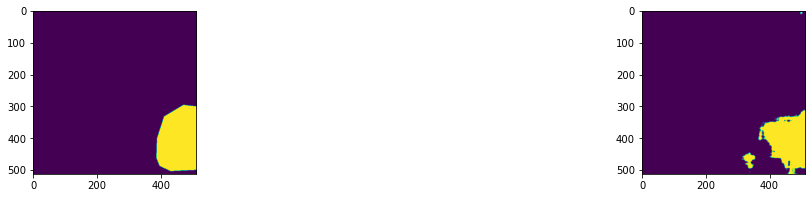

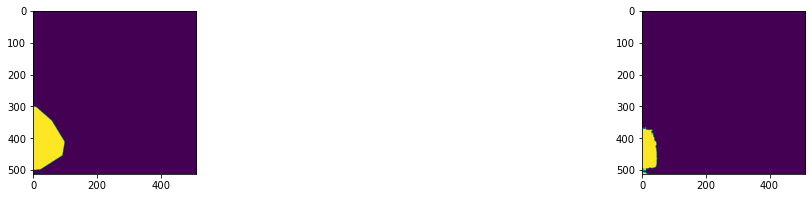

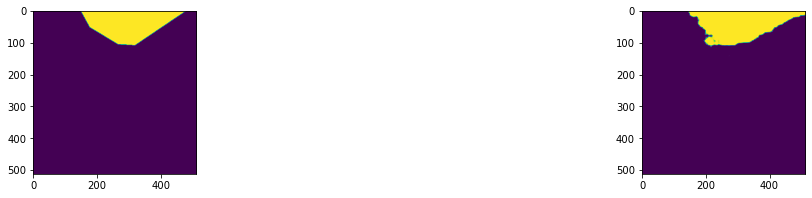

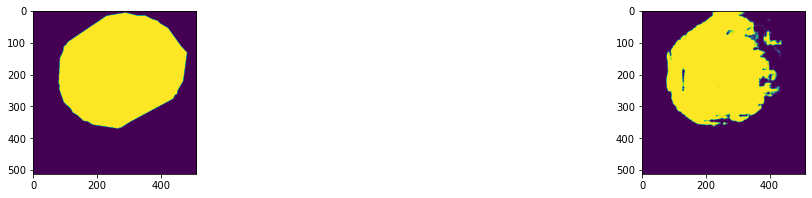

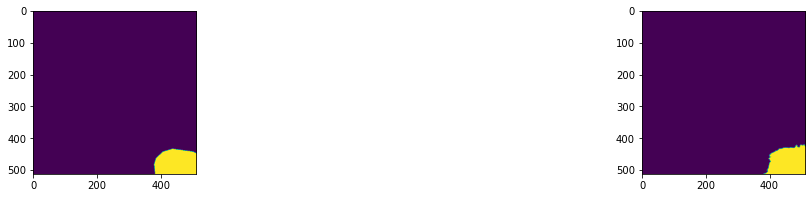

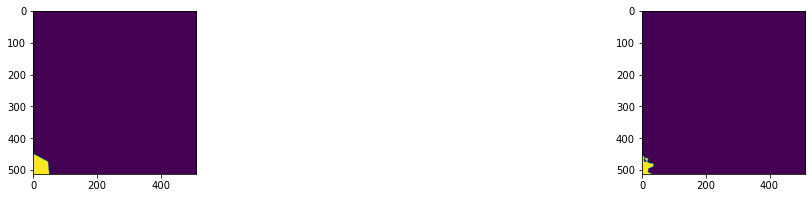

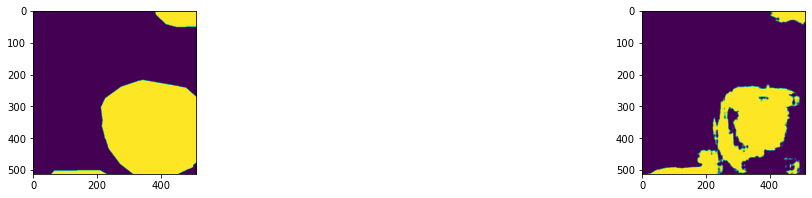

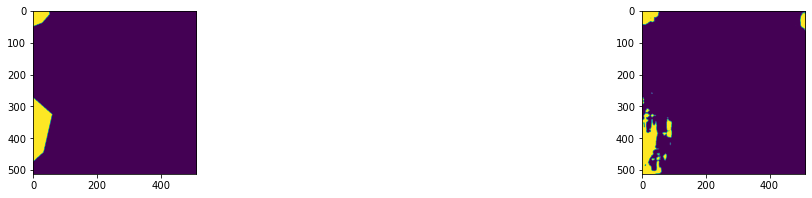

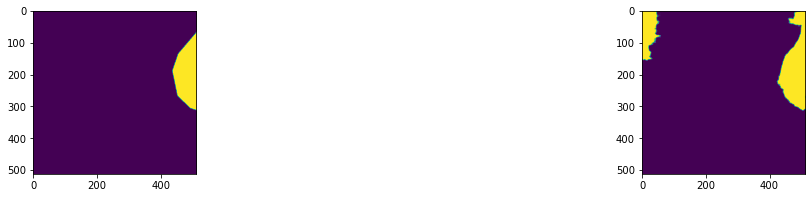

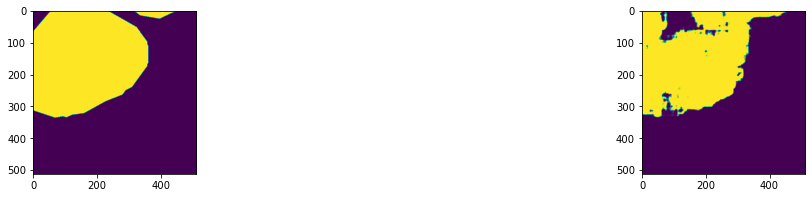

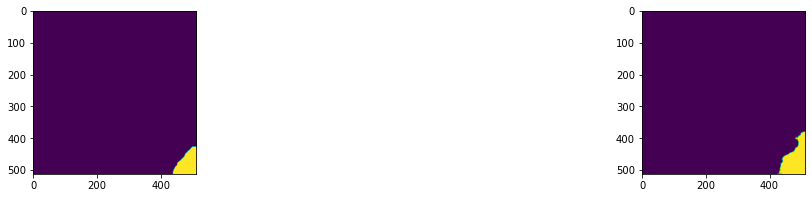

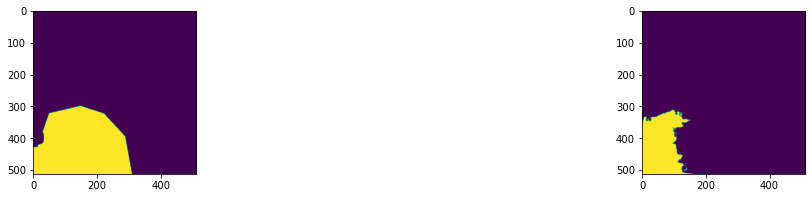

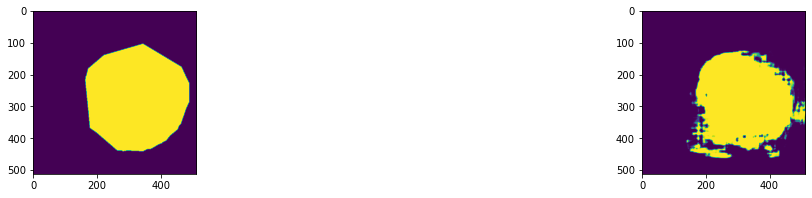

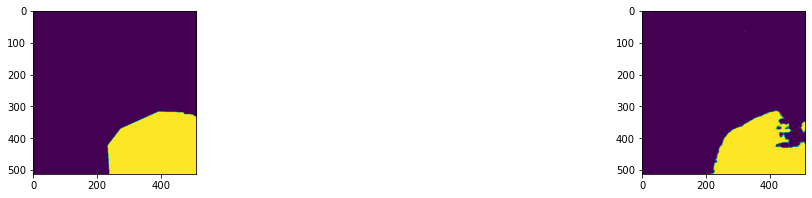

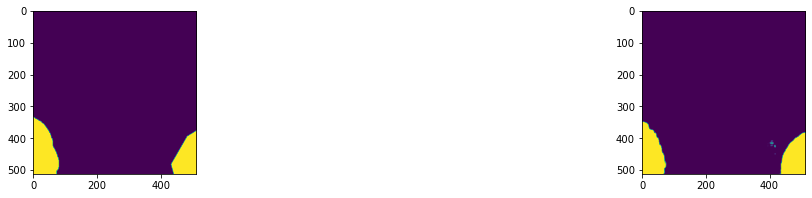

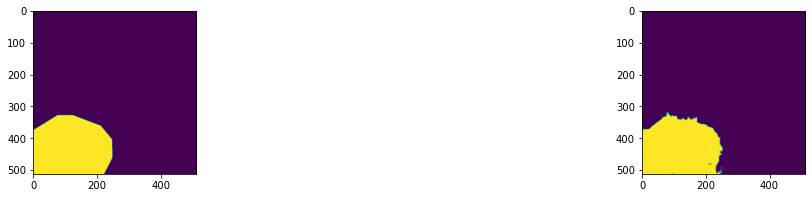

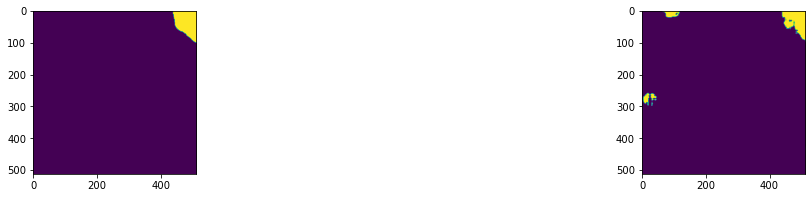

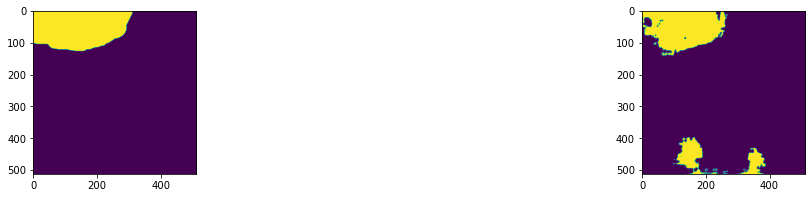

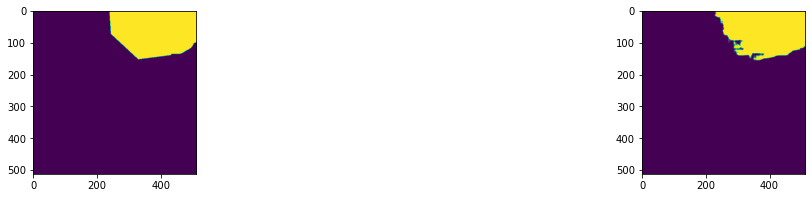

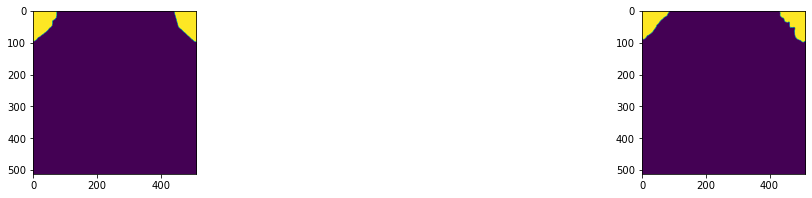

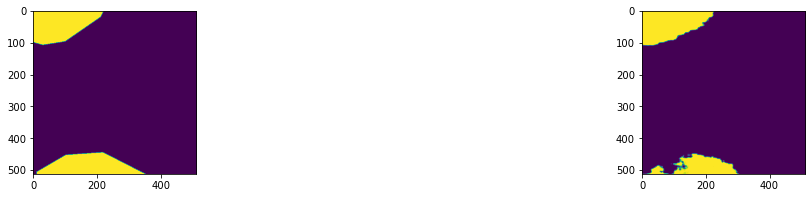

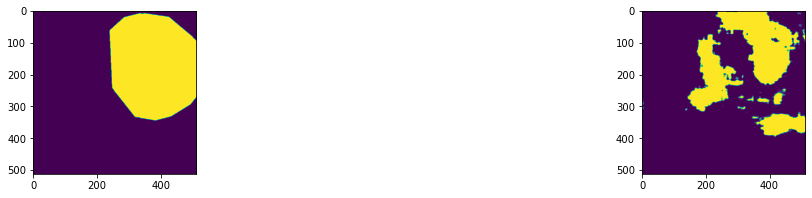

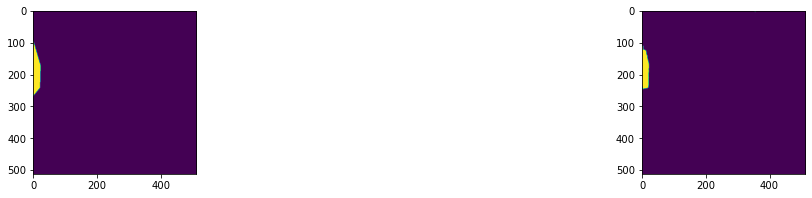

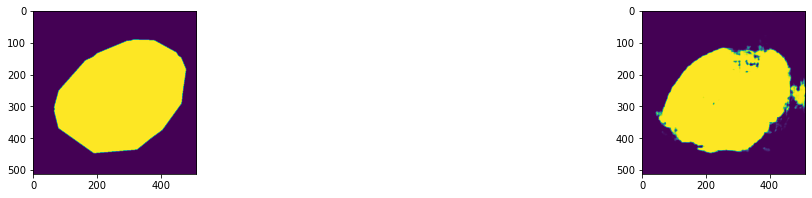

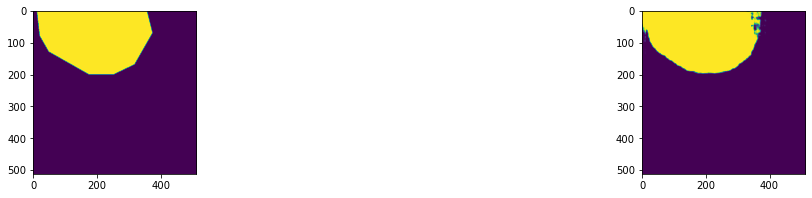

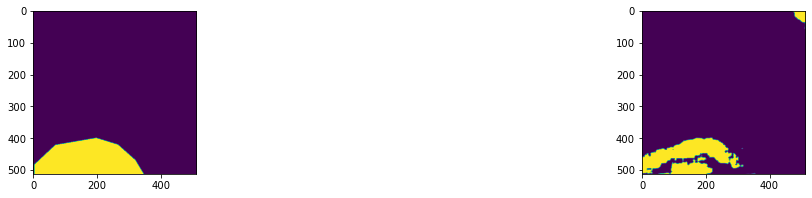

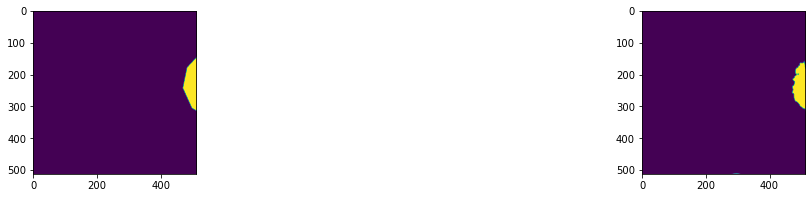

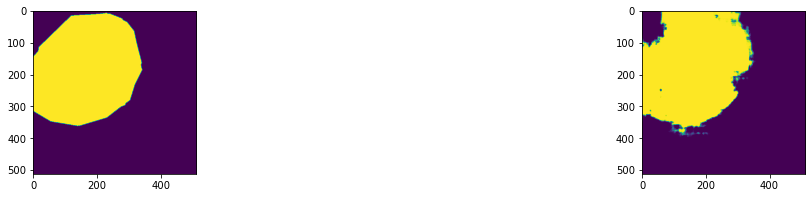

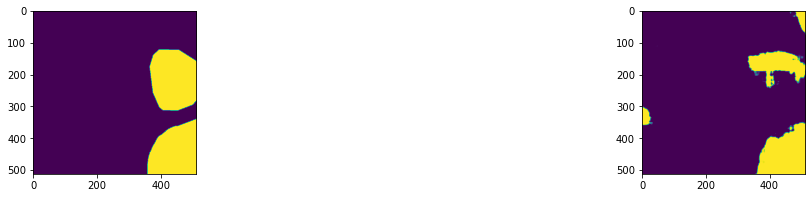

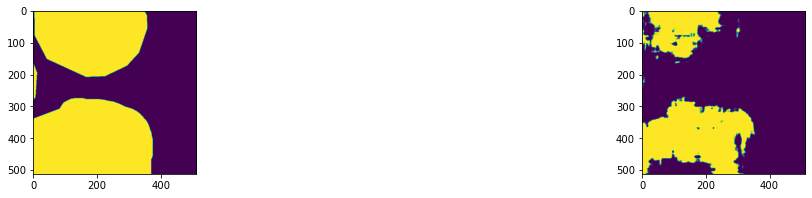

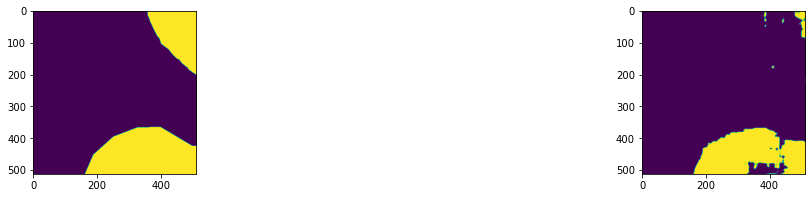

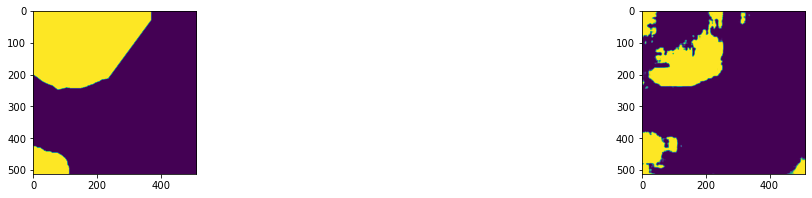

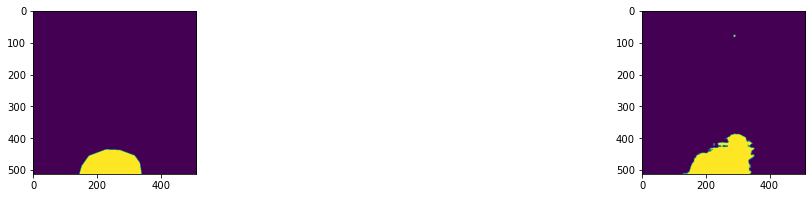

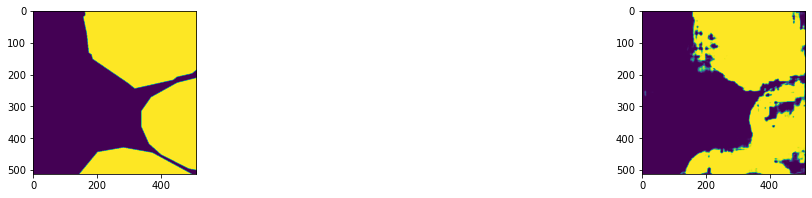

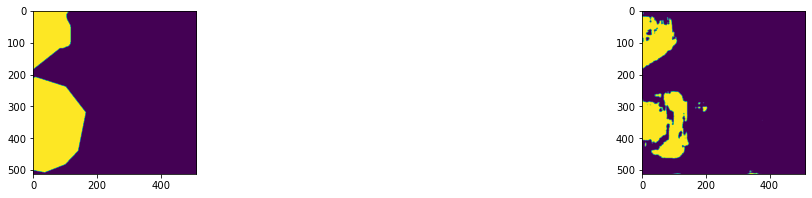

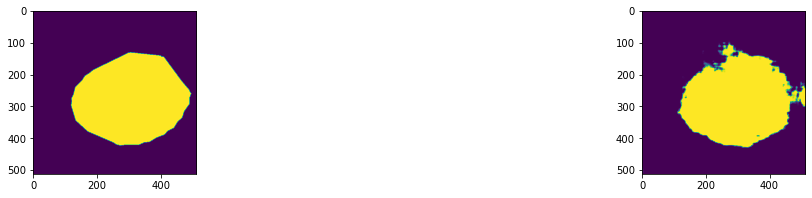

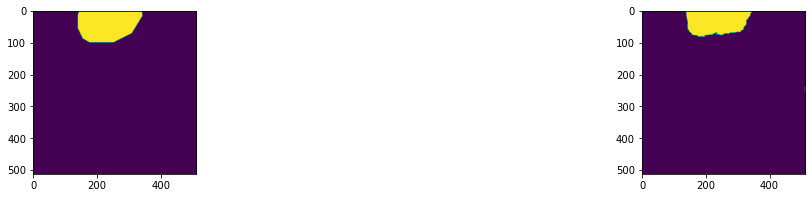

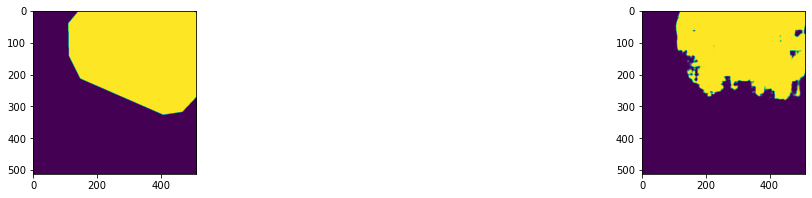

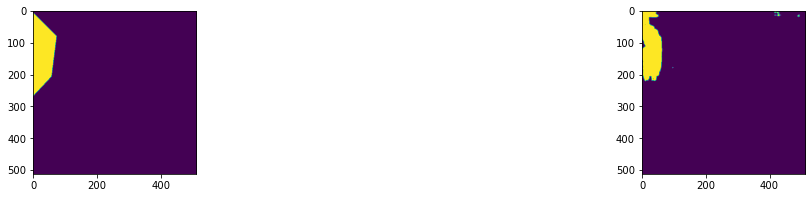

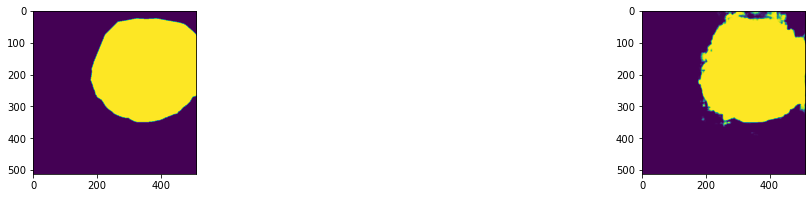

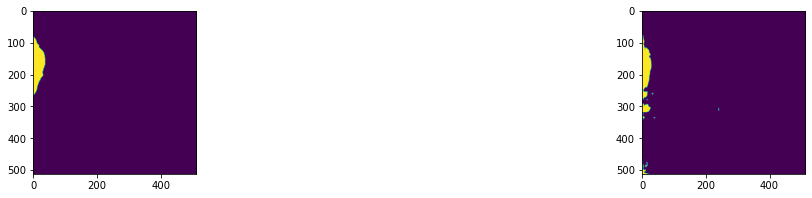

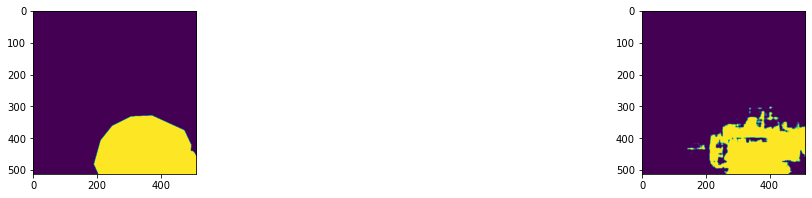

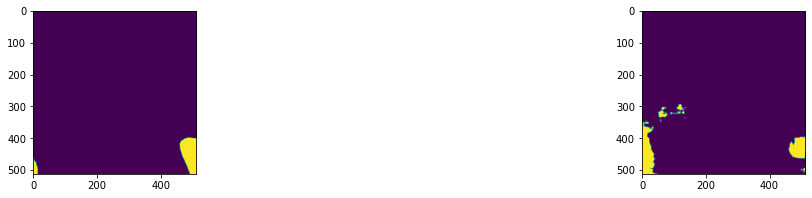

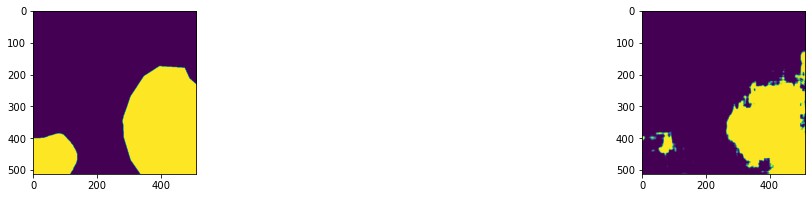

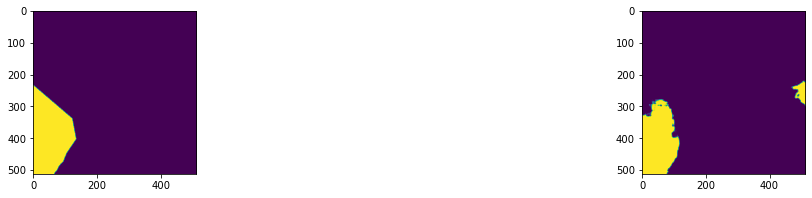

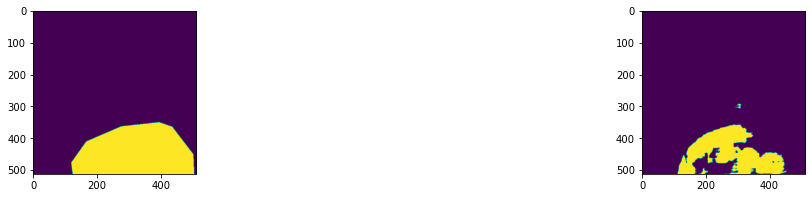

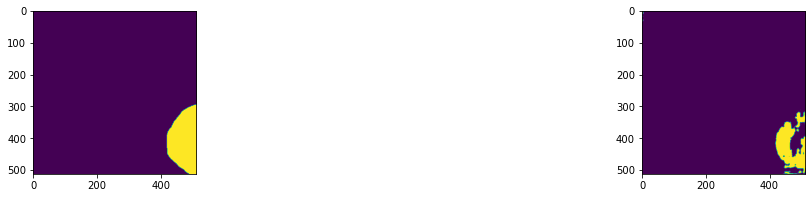

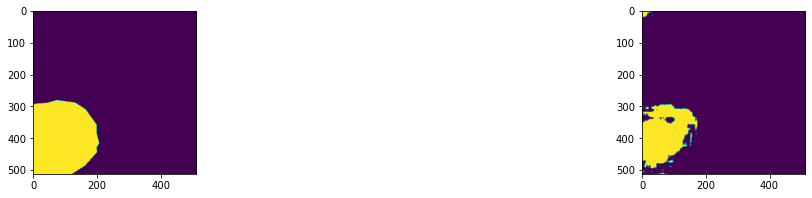

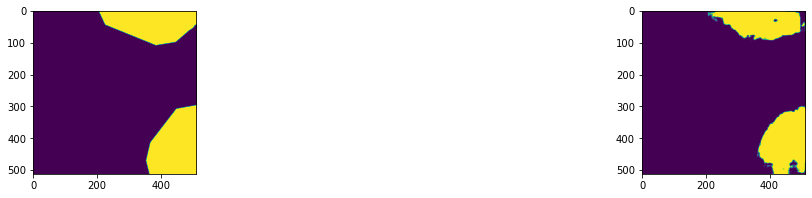

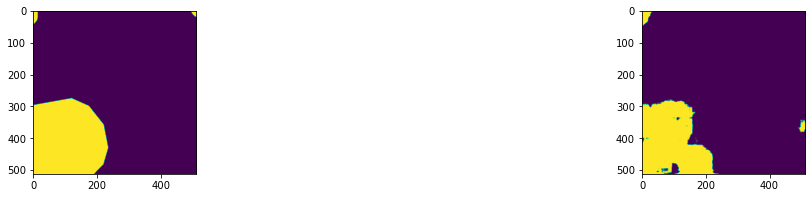

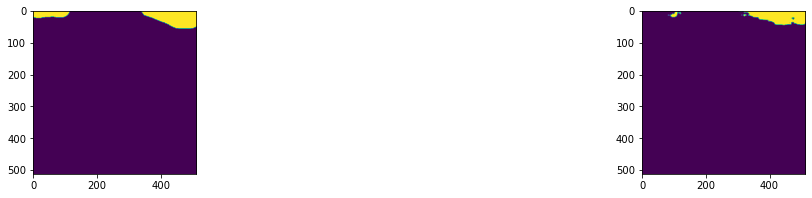

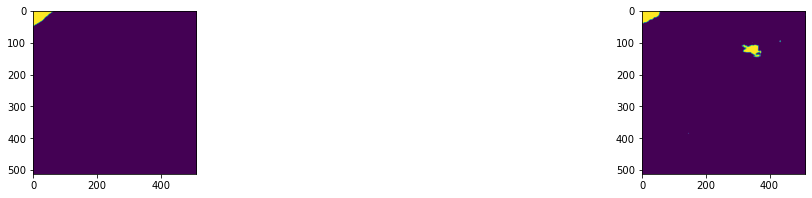

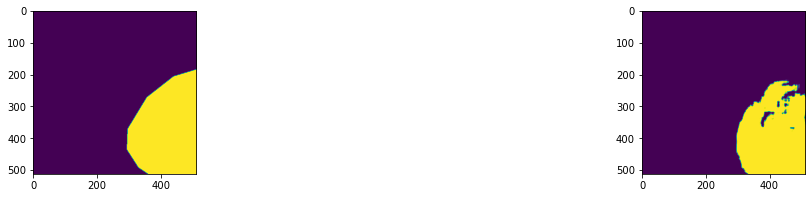

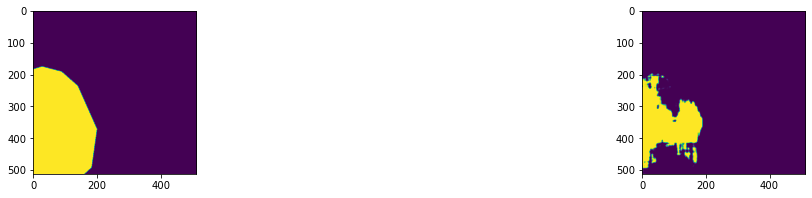

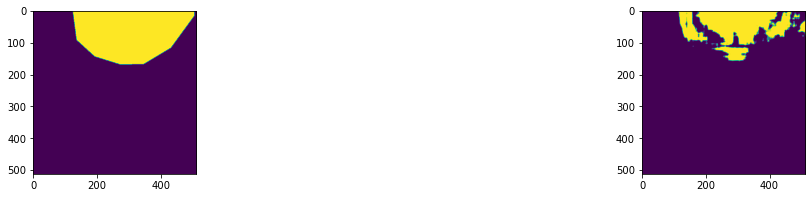

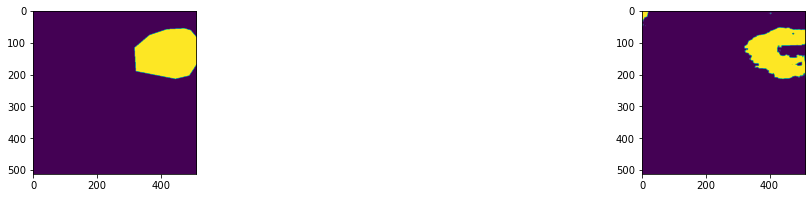

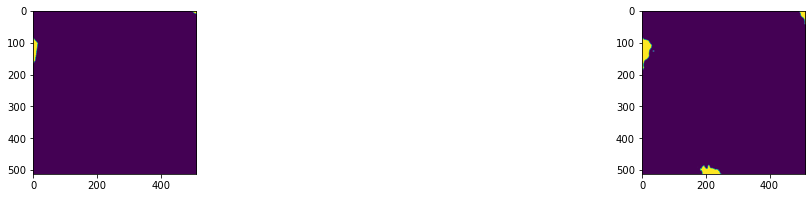

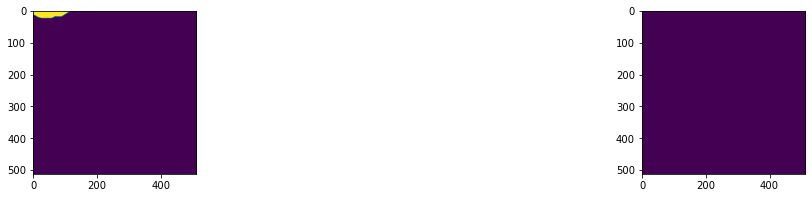

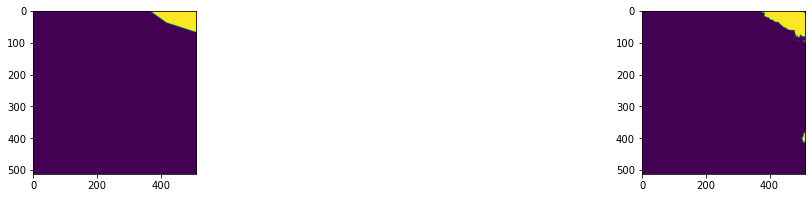

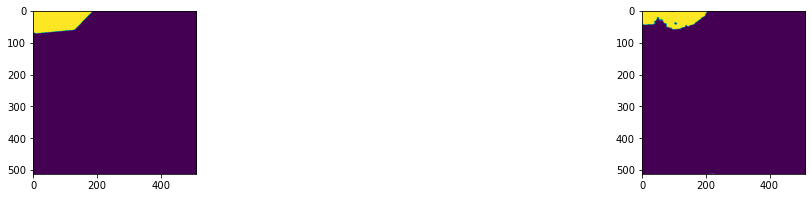

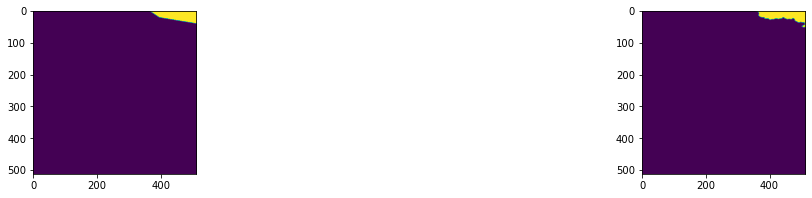

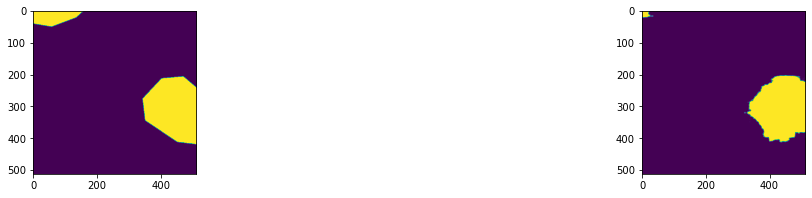

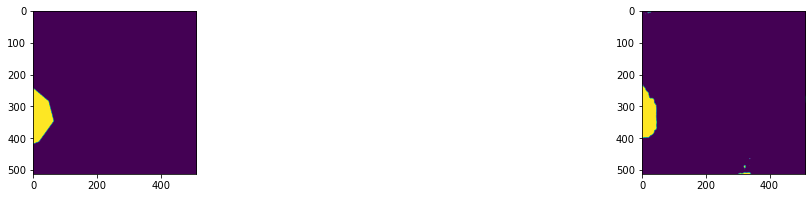

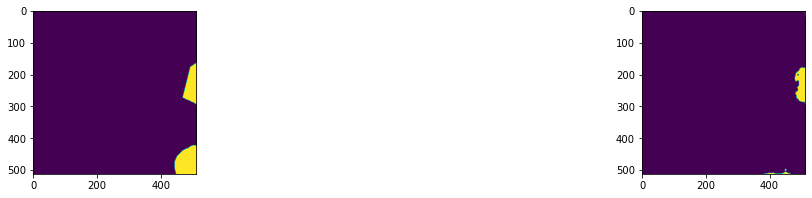

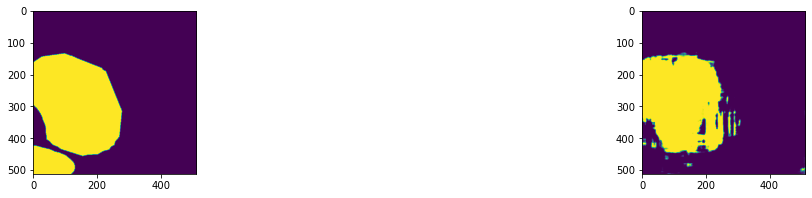

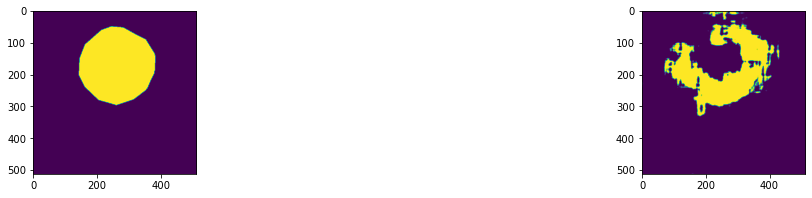

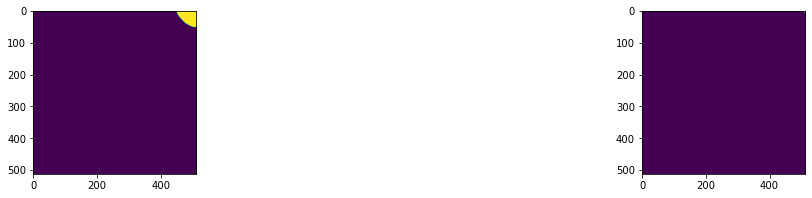

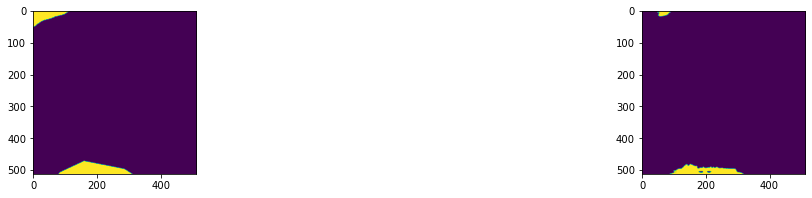

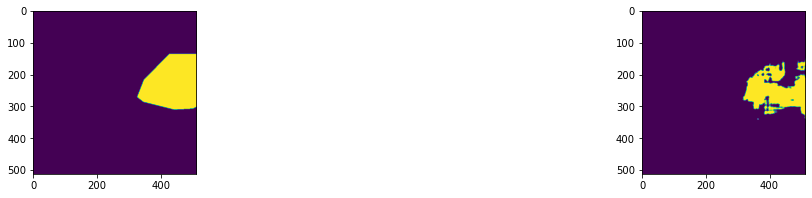

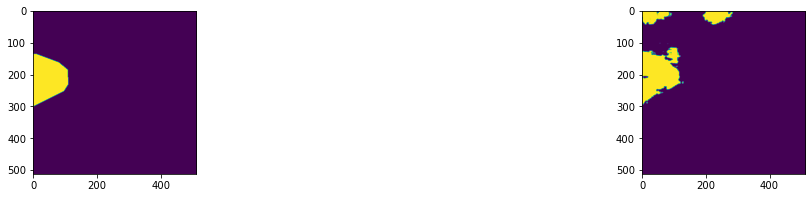

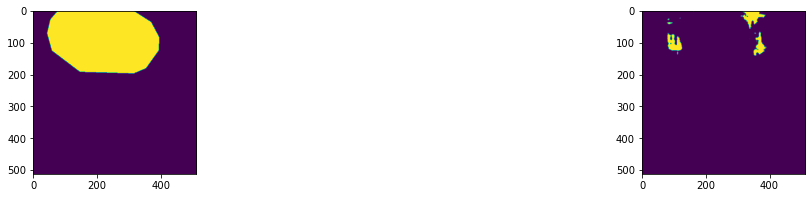

In [234]:
# Testing for a test image
validation = train_all_df
images = validation.img_id.unique()

for img in images[0:1]: 
    test_chunk = validation[validation['img_id'] == img]
    rows, cols = (test_chunk.iloc[-1, :].tile_row_index, test_chunk.iloc[-1, :].tile_col_index)
    test_chunk_paths = test_chunk['local_path']
    
    test_row_col = test_chunk[['tile_row_index', 'tile_col_index']]
    
    test_dataset = read_images_and_masks(test_chunk_paths)
    test_final = np.zeros ((1, (rows+1)*512, (cols+1)*512))
    pred_final = np.zeros ((1, (rows+1)*512, (cols+1)*512))
    
    for (image, mask), (index, row_col) in zip (test_dataset, test_row_col.iterrows()):
        row, col = row_col['tile_row_index'], row_col['tile_col_index']
        test_image, test_mask = image, mask
        pred_mask = unet_model.predict(test_image, verbose=1)
        bool_mask = pred_mask[:,:] > 0.5
        bool_ = bool_mask.reshape((1,512,512))
        is_all_zero = np.all((test_mask == 0))
        if (is_all_zero == False):
            fig, ax = plt.subplots(1,2,figsize=(20,3))
            ax[0].imshow(test_mask[0,:,:])
            ax[1].imshow(pred_mask[0,:,:])
        test_final[0, row*512:(row+1)*512,col*512:(col+1)*512] = test_mask[0,:,:]
        pred_final[0, row*512:(row+1)*512,col*512:(col+1)*512] = bool_[0,:,:]

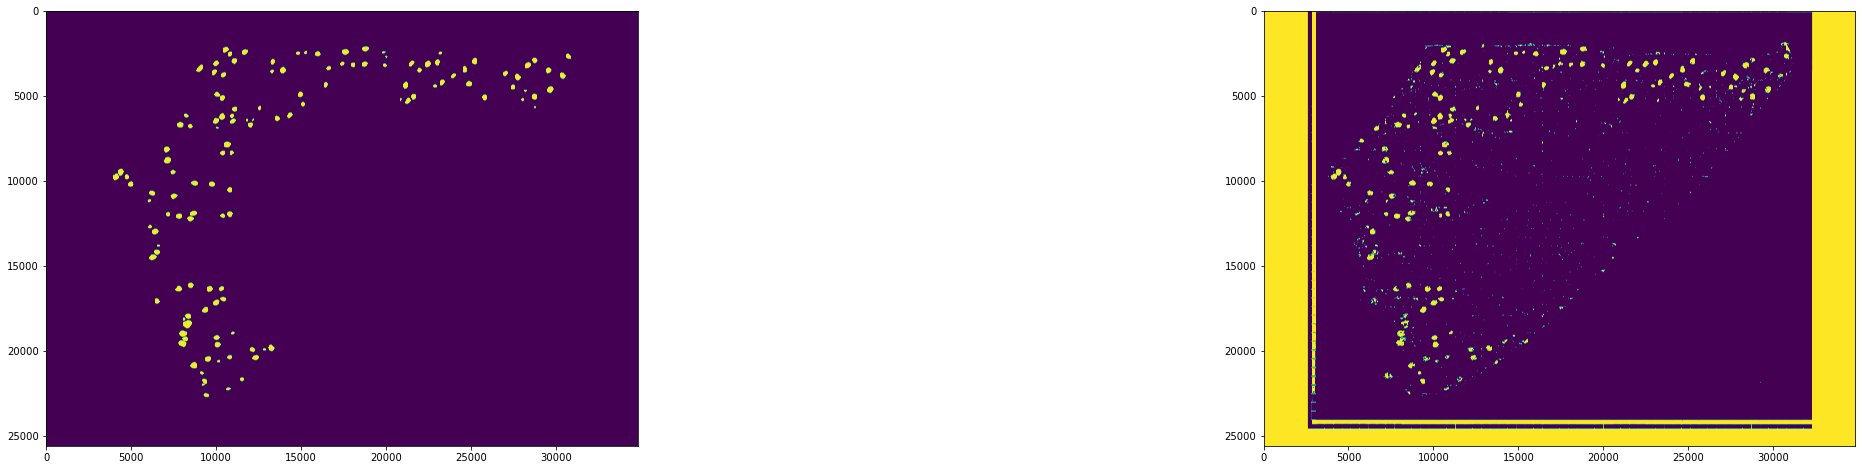

In [242]:
fig, ax = plt.subplots(1,2,figsize=(40,8))
ax[0].imshow(test_final[0,:,:])
ax[1].imshow(pred_final[0,:,:])
plt.savefig('Restitched.png')

In [240]:
print ("Dice Coefficient - " , dice_coeff(test_final, pred_final))
print ("Dice Loss - ", dice_loss(test_final, pred_final))

Dice Coefficient -  tf.Tensor(0.08069332522078039, shape=(), dtype=float64)
Dice Loss -  tf.Tensor(0.9193066747792196, shape=(), dtype=float64)


In [241]:
print ("Pixel Accuracy - " , pixel_accuracy(test_final.flatten(order='C'), 1*pred_final.flatten(order='C')))
print ("Jaccard Index - ", jaccard_score(test_final[0,:,:].flatten(order='C'), 1*pred_final[0,:,:].flatten(order='C')))
print ("Hausdorff Distance - ", directed_hausdorff(test_final[0,:,:], pred_final[0,:,:]))

Pixel Accuracy -  0.7948867315404555
Jaccard Index -  0.04204295555324016
Hausdorff Distance -  (79.49842765740716, 4447, 4390)


#### Points to be noted: 
 1. Balanced data and data with only gloms
 2. Different number of epochs
 3. Tile restitching
 4. 1 epoch takes about 1 hour